<h1>Background Correction</h1>

In [1]:
import os
import pandas as pd
import seaborn as sns
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from scipy.interpolate import interp1d

In [2]:
# Create folder in which all figures and files are being saved
os.makedirs('Data_Cleaning', exist_ok=True)

<h2>1. Heatmap Raw traces</h2>

In [3]:
# Load raw dataset
data = pd.read_csv('../data/all_traces.tsv', sep='\t') # add sep='\t' when dealing with a tsv file instead of a csv file
data.shape # quick overview of loaded dataset

(2825, 64)

In [4]:
# ensure that re-occurring video names do not cause the two classes to mix
data.video = data.apply(lambda s: f'{s.label}_{s.video}', axis=1)
# set a multi-index
data = data.set_index(['label', 'video', 'trace'])
data.head()

time_0  time_10  time_20  time_30  time_40  \
label video    trace                                                    
PR8   PR8_1001 trace_001  105.694  105.319  105.368  105.736  105.986   
               trace_002  105.778  104.826  105.014  104.972  105.542   
               trace_003  104.819  104.042  103.083  104.604  104.472   
               trace_004  103.306  103.062  103.062  102.792  102.694   
               trace_005  116.576  115.097  116.771  117.715  117.576   

                          time_50  time_60  time_70  time_80  time_90  ...  \
label video    trace                                                   ...   
PR8   PR8_1001 trace_001  106.014  105.208  105.632  105.681  105.778  ...   
               trace_002  105.056  105.479  105.535  105.125  105.056  ...   
               trace_003  104.326  104.444  103.917  104.236  104.236  ...   
               trace_004  103.264  103.451  103.243  103.465  103.264  ...   
               trace_005  116.104  115.410  117.181  118.021  117.785  ...   

                          time_510  time_520  time_530  time_540  time_550  \
label video    trace                                                         
PR8   PR8_1001 trace_001   105.194   104.625   104.708   104.451   104.486   
               trace_002   104.257   104.083   104.778   104.347   104.569   
               trace_003   104.521   104.431   103.944   103.785   104.083   
               trace_004   103.583   103.507   102.806   102.625   103.479   
               trace_005   131.035   126.917   122.639   125.868   126.264   

                          time_560  time_570  time_580  time_590  time_600  
label video    trace                                                        
PR8   PR8_1001 trace_001   104.910   104.951   105.222   104.396   104.375  
               trace_002   103.924   103.715   104.382   104.618   104.090  
               trace_003   104.368   103.472   103.736   103.833   105.097  
               trace_004   102.903   103.076   102.896   103.250   103.215  
               trace_005   124.875   122.917   118.000   121.806   121.069  

[5 rows x 61 columns]

In [5]:
# Transpose raw dataset
data.T

label          PR8                                                    \
video     PR8_1001                                                     
trace    trace_001 trace_002 trace_003 trace_004 trace_005 trace_006   
time_0     105.694   105.778   104.819   103.306   116.576   105.181   
time_10    105.319   104.826   104.042   103.062   115.097   105.021   
time_20    105.368   105.014   103.083   103.062   116.771   105.250   
time_30    105.736   104.972   104.604   102.792   117.715   105.083   
time_40    105.986   105.542   104.472   102.694   117.576   105.361   
...            ...       ...       ...       ...       ...       ...   
time_560   104.910   103.924   104.368   102.903   124.875   104.208   
time_570   104.951   103.715   103.472   103.076   122.917   104.340   
time_580   105.222   104.382   103.736   102.896   118.000   104.757   
time_590   104.396   104.618   103.833   103.250   121.806   104.319   
time_600   104.375   104.090   105.097   103.215   121.069   105.542   

label                                             ...       X31            \
video                                             ...  X31_5003             
trace    trace_007 trace_008 trace_009 trace_010  ... trace_099 trace_100   
time_0     107.097   104.319   105.597   107.326  ...   108.382   114.701   
time_10    107.278   103.660   106.486   106.736  ...   107.521   115.201   
time_20    106.812   103.472   105.576   107.472  ...   108.021   114.354   
time_30    107.910   104.188   105.076   108.306  ...   108.667   116.729   
time_40    109.556   104.042   105.347   108.326  ...   108.229   116.049   
...            ...       ...       ...       ...  ...       ...       ...   
time_560   108.257   104.153   106.472   107.208  ...   107.931   114.292   
time_570   106.535   103.590   106.521   106.944  ...   107.972   113.076   
time_580   106.493   103.118   106.785   107.889  ...   107.194   112.375   
time_590   107.569   103.431   105.806   108.208  ...   107.931   115.444   
time_600   106.799   103.729   105.861   107.361  ...   108.236   115.979   

label                                                                 \
video                                                                  
trace    trace_101 trace_102 trace_103 trace_104 trace_105 trace_106   
time_0     107.785   113.812   110.042   111.236   107.492   114.056   
time_10    108.049   115.035   109.486   109.465   106.892   113.264   
time_20    108.285   115.243   108.986   110.569   108.833   112.410   
time_30    108.382   116.208   111.028   111.132   108.083   114.396   
time_40    109.090   118.056   109.889   110.924   108.042   112.944   
...            ...       ...       ...       ...       ...       ...   
time_560   108.507   113.083   110.375   107.167   106.400   116.778   
time_570   108.472   114.701   111.076   107.583   106.775   117.312   
time_580   108.604   118.250   111.000   107.507   107.167   117.521   
time_590   108.896   121.889   111.167   107.472   106.392   116.708   
time_600   107.931   119.743   112.417   106.764   108.025   117.000   

label                         
video                         
trace    trace_107 trace_108  
time_0     109.868   106.049  
time_10    109.056   106.056  
time_20    109.201   106.625  
time_30    110.194   105.681  
time_40    109.278   106.201  
...            ...       ...  
time_560   109.618   106.451  
time_570   109.493   106.174  
time_580   111.132   105.215  
time_590   111.576   105.028  
time_600   110.750   105.340  

[61 rows x 2825 columns]

In [6]:
def clusmapsns(df: pd.DataFrame, dateiname='plot.png', y_label='GFP intensity [a.u.]', cluster: bool = False):
    df = df.copy()

    # --- Extract label/video levels ---
    labels = df.T.columns.get_level_values('label')
    videos = df.T.columns.get_level_values('video')

    # --- Define label-level color palette consistent with compare_strains() ---
    # PR8 -> blue, X31 -> orange
    label_palette = {
        'PR8': 'tab:blue',
        'X31': 'tab:orange'
    }

    # Map the colors, fallback to gray if unknown label
    label_colors = labels.map(lambda x: label_palette.get(x, 'gray'))

    # --- Define video colors (still random for visual separation) ---
    all_videos = videos.unique()
    combined_palette = sns.color_palette("tab20b", len(all_videos) // 2) + \
                       sns.color_palette("tab20c", len(all_videos) - len(all_videos) // 2)
    random.Random(4).shuffle(combined_palette)

    video_palette = dict(zip(all_videos, combined_palette))
    video_colors = videos.map(video_palette)

    # --- Combine into col_colors ---
    col_colors = pd.DataFrame({
        'Strain': label_colors,
        'Video': video_colors
    }, index=df.T.columns)

    # --- Create clustermap ---
    g = sns.clustermap(df.T,
                       method='ward',
                       metric='euclidean',
                       figsize=(20, 10),
                       row_cluster=False,
                       col_cluster=cluster,
                       dendrogram_ratio=(0.001, 0.001),
                       col_colors=col_colors,
                       cmap="Greys_r",
                       cbar_pos=(1, 0.08, 0.02, 0.6),
                       yticklabels=False,
                       xticklabels=False)

    # --- Adjust colorbar ---
    heatmap_pos = g.ax_heatmap.get_position()
    cbar_width = 0.02
    cbar_x = heatmap_pos.x1 + 0.01
    g.cax.set_position([cbar_x, heatmap_pos.y0, cbar_width, heatmap_pos.height])

    # Add black border around colorbar
    for spine in g.cax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)
        spine.set_visible(True)

    g.cax.set_ylabel(y_label, rotation=270, labelpad=15, fontsize=12)
    g.ax_heatmap.set_xlabel('')

    g.savefig(dateiname, dpi=300)
    return g

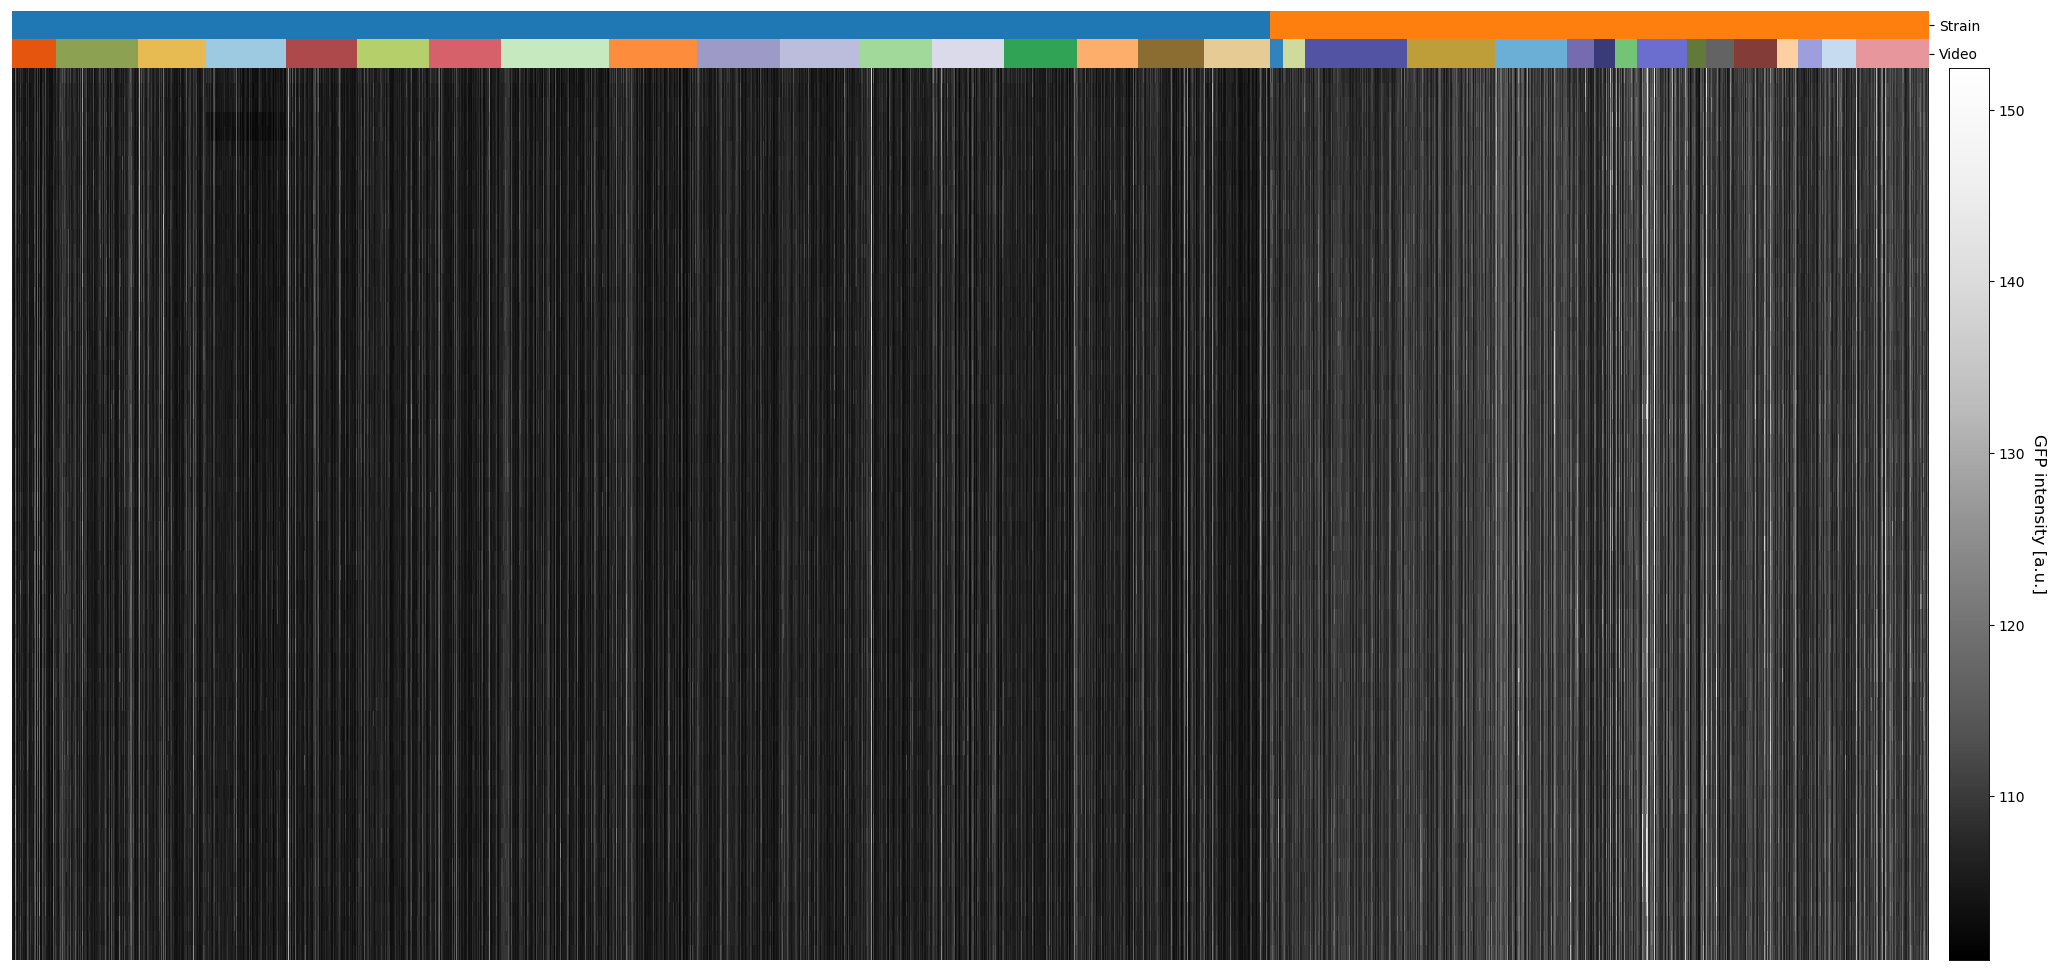

In [7]:
g = clusmapsns(df=data, dateiname='Data_Cleaning/Heatmap_raw_traces.png')
# Show and save
plt.show()

<h2>2. Heatmap normalized traces</h2>

In [8]:
# Load and process normalized dataset
data_norm = pd.read_csv('Exploring_Dataset/all_traces_norm.tsv', sep='\t')
data_norm.video = data_norm.apply(lambda s: f'{s.label}_{s.video}', axis=1)
data_norm = data_norm.set_index(['label', 'video', 'trace'])
data_norm.head()

time_0   time_10   time_20   time_30   time_40  \
label video    trace                                                         
PR8   PR8_1001 trace_001  0.701169  0.544658  0.565109  0.718698  0.823038   
               trace_002  1.000000  0.612851  0.689305  0.672224  0.904026   
               trace_003  0.507009  0.280082  0.000000  0.444217  0.405666   
               trace_004  0.770064  0.614650  0.614650  0.442675  0.380255   
               trace_005  0.239840  0.162084  0.250092  0.299721  0.292414   

                           time_50   time_60   time_70   time_80   time_90  \
label video    trace                                                         
PR8   PR8_1001 trace_001  0.834725  0.498331  0.675292  0.695743  0.736227   
               trace_002  0.706385  0.878406  0.901179  0.734445  0.706385   
               trace_003  0.363026  0.397488  0.243575  0.336741  0.336741   
               trace_004  0.743312  0.862420  0.729936  0.871338  0.743312   
               trace_005  0.215025  0.178540  0.271647  0.315809  0.303402   

                          ...  time_510  time_520  time_530  time_540  \
label video    trace      ...                                           
PR8   PR8_1001 trace_001  ...  0.492487  0.255008  0.289649  0.182387   
               trace_002  ...  0.381456  0.310695  0.593331  0.418056   
               trace_003  ...  0.419977  0.393692  0.251460  0.205023   
               trace_004  ...  0.946497  0.898089  0.451592  0.336306   
               trace_005  ...  1.000000  0.783502  0.558593  0.728353   

                          time_550  time_560  time_570  time_580  time_590  \
label video    trace                                                         
PR8   PR8_1001 trace_001  0.196995  0.373957  0.391068  0.504174  0.159432   
               trace_002  0.508337  0.246035  0.161041  0.432290  0.528264   
               trace_003  0.292056  0.375292  0.113610  0.190713  0.219042   
               trace_004  0.880255  0.513376  0.623567  0.508917  0.734395   
               trace_005  0.749172  0.676147  0.573209  0.314705  0.514799   

                          time_600  
label video    trace                
PR8   PR8_1001 trace_001  0.150668  
               trace_002  0.313542  
               trace_003  0.588201  
               trace_004  0.712102  
               trace_005  0.476053  

[5 rows x 61 columns]

Again we transpose the dataset for the clustermap

In [9]:
data_norm.T

label          PR8                                                    \
video     PR8_1001                                                     
trace    trace_001 trace_002 trace_003 trace_004 trace_005 trace_006   
time_0    0.701169  1.000000  0.507009  0.770064  0.239840  0.558914   
time_10   0.544658  0.612851  0.280082  0.614650  0.162084  0.476947   
time_20   0.565109  0.689305  0.000000  0.614650  0.250092  0.594262   
time_30   0.718698  0.672224  0.444217  0.442675  0.299721  0.508709   
time_40   0.823038  0.904026  0.405666  0.380255  0.292414  0.651127   
...            ...       ...       ...       ...       ...       ...   
time_560  0.373957  0.246035  0.375292  0.513376  0.676147  0.060451   
time_570  0.391068  0.161041  0.113610  0.623567  0.573209  0.128074   
time_580  0.504174  0.432290  0.190713  0.508917  0.314705  0.341701   
time_590  0.159432  0.528264  0.219042  0.734395  0.514799  0.117316   
time_600  0.150668  0.313542  0.588201  0.712102  0.476053  0.743852   

label                                             ...       X31            \
video                                             ...  X31_5003             
trace    trace_007 trace_008 trace_009 trace_010  ... trace_099 trace_100   
time_0    0.216474  0.955200  0.142078  0.348308  ...  0.864993  0.262848   
time_10   0.249099  0.603733  0.384510  0.166769  ...  0.457129  0.304904   
time_20   0.165105  0.503467  0.136351  0.393231  ...  0.693984  0.233661   
time_30   0.363014  0.885333  0.000000  0.649846  ...  1.000000  0.433426   
time_40   0.659697  0.807467  0.073902  0.656000  ...  0.792515  0.376230   
...            ...       ...       ...       ...  ...       ...       ...   
time_560  0.425559  0.866667  0.380693  0.312000  ...  0.651350  0.228446   
time_570  0.115177  0.566400  0.394055  0.230769  ...  0.670772  0.126167   
time_580  0.107606  0.314667  0.466049  0.521538  ...  0.302226  0.067205   
time_590  0.301550  0.481600  0.199073  0.619692  ...  0.651350  0.325343   
time_600  0.162761  0.640533  0.214071  0.359077  ...  0.795831  0.370342   

label                                                                 \
video                                                                  
trace    trace_101 trace_102 trace_103 trace_104 trace_105 trace_106   
time_0    0.060288  0.356972  0.165284  0.766672   0.57088  0.116022   
time_10   0.103539  0.448363  0.078260  0.463055   0.37888  0.060196   
time_20   0.142202  0.463907  0.000000  0.652323   1.00000  0.000000   
time_30   0.158093  0.536019  0.319612  0.748843   0.76000  0.139987   
time_40   0.274083  0.674114  0.141337  0.713184   0.74688  0.037640   
...            ...       ...       ...       ...       ...       ...   
time_560  0.178571  0.302496  0.217405  0.069090   0.22144  0.307888   
time_570  0.172837  0.423405  0.327125  0.140408   0.34144  0.345528   
time_580  0.194463  0.688612  0.315229  0.127379   0.46688  0.360259   
time_590  0.242300  0.960544  0.341368  0.121378   0.21888  0.302953   
time_600  0.084207  0.800179  0.537017  0.000000   0.74144  0.323536   

label                         
video                         
trace    trace_107 trace_108  
time_0    0.189023  0.505195  
time_10   0.010757  0.508659  
time_20   0.042591  0.790203  
time_30   0.260593  0.323107  
time_40   0.059495  0.580406  
...            ...       ...  
time_560  0.134138  0.704107  
time_570  0.106696  0.567046  
time_580  0.466520  0.092528  
time_590  0.563996  0.000000  
time_600  0.382656  0.154379  

[61 rows x 2825 columns]

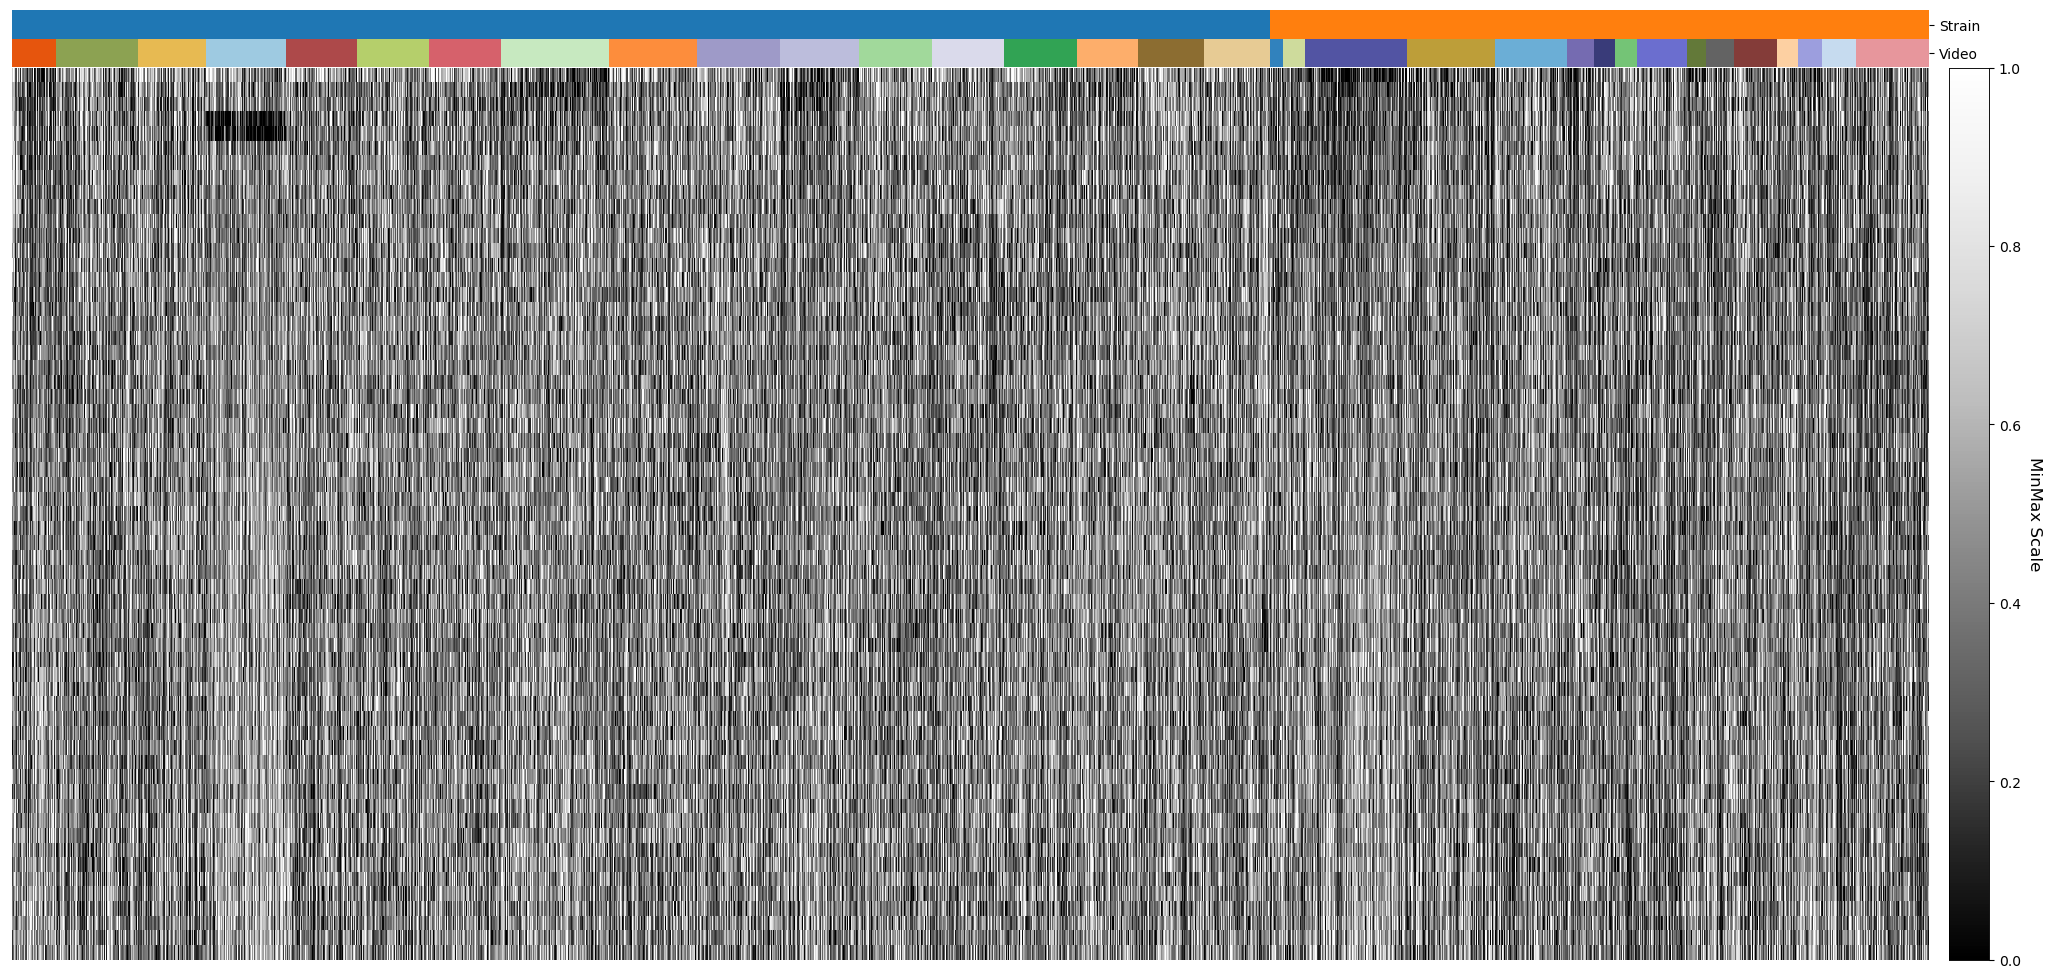

In [10]:
g = clusmapsns(df=data_norm, dateiname='Data_Cleaning/Heatmap_norm_traces.png', y_label='MinMax Scale')
# Show and save
plt.show()

<h3>2.1 Clustermap Normalized traces</h3>

In [11]:
# Load and process normalized dataset
data_norm1 = pd.read_csv('Exploring_Dataset/all_traces_norm.tsv', sep='\t')
data_norm1.video = data_norm1.apply(lambda s: f'{s.label}_{s.video}', axis=1)
data_norm1 = data_norm1.set_index(['label', 'video', 'trace'])
data_norm1

time_0   time_10   time_20   time_30   time_40  \
label video    trace                                                         
PR8   PR8_1001 trace_001  0.701169  0.544658  0.565109  0.718698  0.823038   
               trace_002  1.000000  0.612851  0.689305  0.672224  0.904026   
               trace_003  0.507009  0.280082  0.000000  0.444217  0.405666   
               trace_004  0.770064  0.614650  0.614650  0.442675  0.380255   
               trace_005  0.239840  0.162084  0.250092  0.299721  0.292414   
...                            ...       ...       ...       ...       ...   
X31   X31_5003 trace_104  0.766672  0.463055  0.652323  0.748843  0.713184   
               trace_105  0.570880  0.378880  1.000000  0.760000  0.746880   
               trace_106  0.116022  0.060196  0.000000  0.139987  0.037640   
               trace_107  0.189023  0.010757  0.042591  0.260593  0.059495   
               trace_108  0.505195  0.508659  0.790203  0.323107  0.580406   

                           time_50   time_60   time_70   time_80   time_90  \
label video    trace                                                         
PR8   PR8_1001 trace_001  0.834725  0.498331  0.675292  0.695743  0.736227   
               trace_002  0.706385  0.878406  0.901179  0.734445  0.706385   
               trace_003  0.363026  0.397488  0.243575  0.336741  0.336741   
               trace_004  0.743312  0.862420  0.729936  0.871338  0.743312   
               trace_005  0.215025  0.178540  0.271647  0.315809  0.303402   
...                            ...       ...       ...       ...       ...   
X31   X31_5003 trace_104  0.857192  1.000000  0.740442  0.798903  0.535745   
               trace_105  0.946880  0.856000  0.821440  0.682880  0.696000   
               trace_106  0.137027  0.118912  0.273631  0.369564  0.084162   
               trace_107  0.410099  0.345993  0.272887  0.707355  0.592975   
               trace_108  0.405245  0.474023  0.309253  0.714498  0.381494   

                          ...  time_510  time_520  time_530  time_540  \
label video    trace      ...                                           
PR8   PR8_1001 trace_001  ...  0.492487  0.255008  0.289649  0.182387   
               trace_002  ...  0.381456  0.310695  0.593331  0.418056   
               trace_003  ...  0.419977  0.393692  0.251460  0.205023   
               trace_004  ...  0.946497  0.898089  0.451592  0.336306   
               trace_005  ...  1.000000  0.783502  0.558593  0.728353   
...                       ...       ...       ...       ...       ...   
X31   X31_5003 trace_104  ...  0.201269  0.073718  0.304817  0.111949   
               trace_105  ...  0.293440  0.469440  0.445440  0.160000   
               trace_106  ...  0.606471  0.464510  0.345528  0.450342   
               trace_107  ...  0.282108  0.338529  0.320088  0.295719   
               trace_108  ...  0.666502  0.257793  0.072241  0.374567   

                          time_550  time_560  time_570  time_580  time_590  \
label video    trace                                                         
PR8   PR8_1001 trace_001  0.196995  0.373957  0.391068  0.504174  0.159432   
               trace_002  0.508337  0.246035  0.161041  0.432290  0.528264   
               trace_003  0.292056  0.375292  0.113610  0.190713  0.219042   
               trace_004  0.880255  0.513376  0.623567  0.508917  0.734395   
               trace_005  0.749172  0.676147  0.573209  0.314705  0.514799   
...                            ...       ...       ...       ...       ...   
X31   X31_5003 trace_104  0.038059  0.069090  0.140408  0.127379  0.121378   
               trace_105  0.370880  0.221440  0.341440  0.466880  0.218880   
               trace_106  0.280468  0.307888  0.345528  0.360259  0.302953   
               trace_107  0.268277  0.134138  0.106696  0.466520  0.563996   
               trace_108  0.378031  0.704107  0.567046  0.092528  0.000000   

                          time_60

In [12]:
def min_max(s: pd.Series | pd.DataFrame) -> pd.Series | pd.DataFrame:
    return (s - s.values.min()) / (s.values.max() - s.values.min())

def clusmapscipy(df: pd.DataFrame, 
                 dateiname='plot.png', 
                 y_label='GFP intensity [a.u.]', 
                 cluster: bool = False, 
                 n_clusters=9, 
                 hack=False):
    df = df.copy()

    # --- Extract metadata from MultiIndex columns (label, video) ---
    labels = df.T.columns.get_level_values('label')
    videos = df.T.columns.get_level_values('video')

    # --- Define label-level color palette consistent with compare_strains() ---
    # PR8 -> blue, X31 -> orange
    label_palette = {
        'PR8': 'tab:blue',
        'X31': 'tab:orange'
    }

    # Map colors, fallback to gray if label unknown
    label_colors = labels.map(lambda x: label_palette.get(x, 'gray'))

    # --- Define video-level color palette (for diversity) ---
    all_videos = videos.unique()
    combined_palette = sns.color_palette("tab20b", len(all_videos) // 2) + \
                       sns.color_palette("tab20c", len(all_videos) - len(all_videos) // 2)
    random.Random(4).shuffle(combined_palette)
    video_palette = dict(zip(all_videos, combined_palette))
    video_colors = videos.map(video_palette)

    # --- Combine into col_colors ---
    col_colors = pd.DataFrame({
        'Strain': label_colors,
        'Video': video_colors
    }, index=df.T.columns)

    # --- Initialize cluster_colors ---
    cluster_colors = None

    # --- Perform clustering if requested ---
    if cluster:
        Z = linkage(df.values, method='ward', metric='euclidean')
        ll = leaves_list(Z)
        clusters = fcluster(Z, t=n_clusters, criterion='maxclust')[ll]
        df = df.iloc[ll]

        # Create cluster color palette
        clu_pal = sns.color_palette("tab20", n_clusters)
        random.Random(4).shuffle(clu_pal)
        cluster_palette = dict(zip(range(1, n_clusters + 1), clu_pal))
        cluster_colors = pd.Series(clusters, index=df.index).map(cluster_palette)

        # Reorder col_colors to match df rows
        col_colors = col_colors.loc[df.index]
        col_colors['Cluster'] = cluster_colors

    # --- Plot clustermap ---
    g = sns.clustermap(
        df.T if not hack else df.apply(min_max, axis=1).T,
        metric='euclidean',
        method='ward',
        figsize=(20, 10),
        row_cluster=False,
        col_cluster=False if cluster else True,
        dendrogram_ratio=(0.001, 0.001),
        col_colors=col_colors,
        cmap="Greys_r",
        cbar_pos=(1, 0.08, 0.02, 0.6),
        yticklabels=False,
        xticklabels=False
    )

    # --- Adjust colorbar position ---
    heatmap_pos = g.ax_heatmap.get_position()
    cbar_width = 0.02
    cbar_x = heatmap_pos.x1 + 0.01
    g.cax.set_position([cbar_x, heatmap_pos.y0, cbar_width, heatmap_pos.height])

    # --- Add black border around colorbar ---
    for spine in g.cax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)
        spine.set_visible(True)

    # --- Label adjustments ---
    g.cax.set_ylabel(y_label, rotation=270, labelpad=15, fontsize=12)
    g.ax_heatmap.set_xlabel('')

    g.savefig(dateiname, dpi=300)
    return g

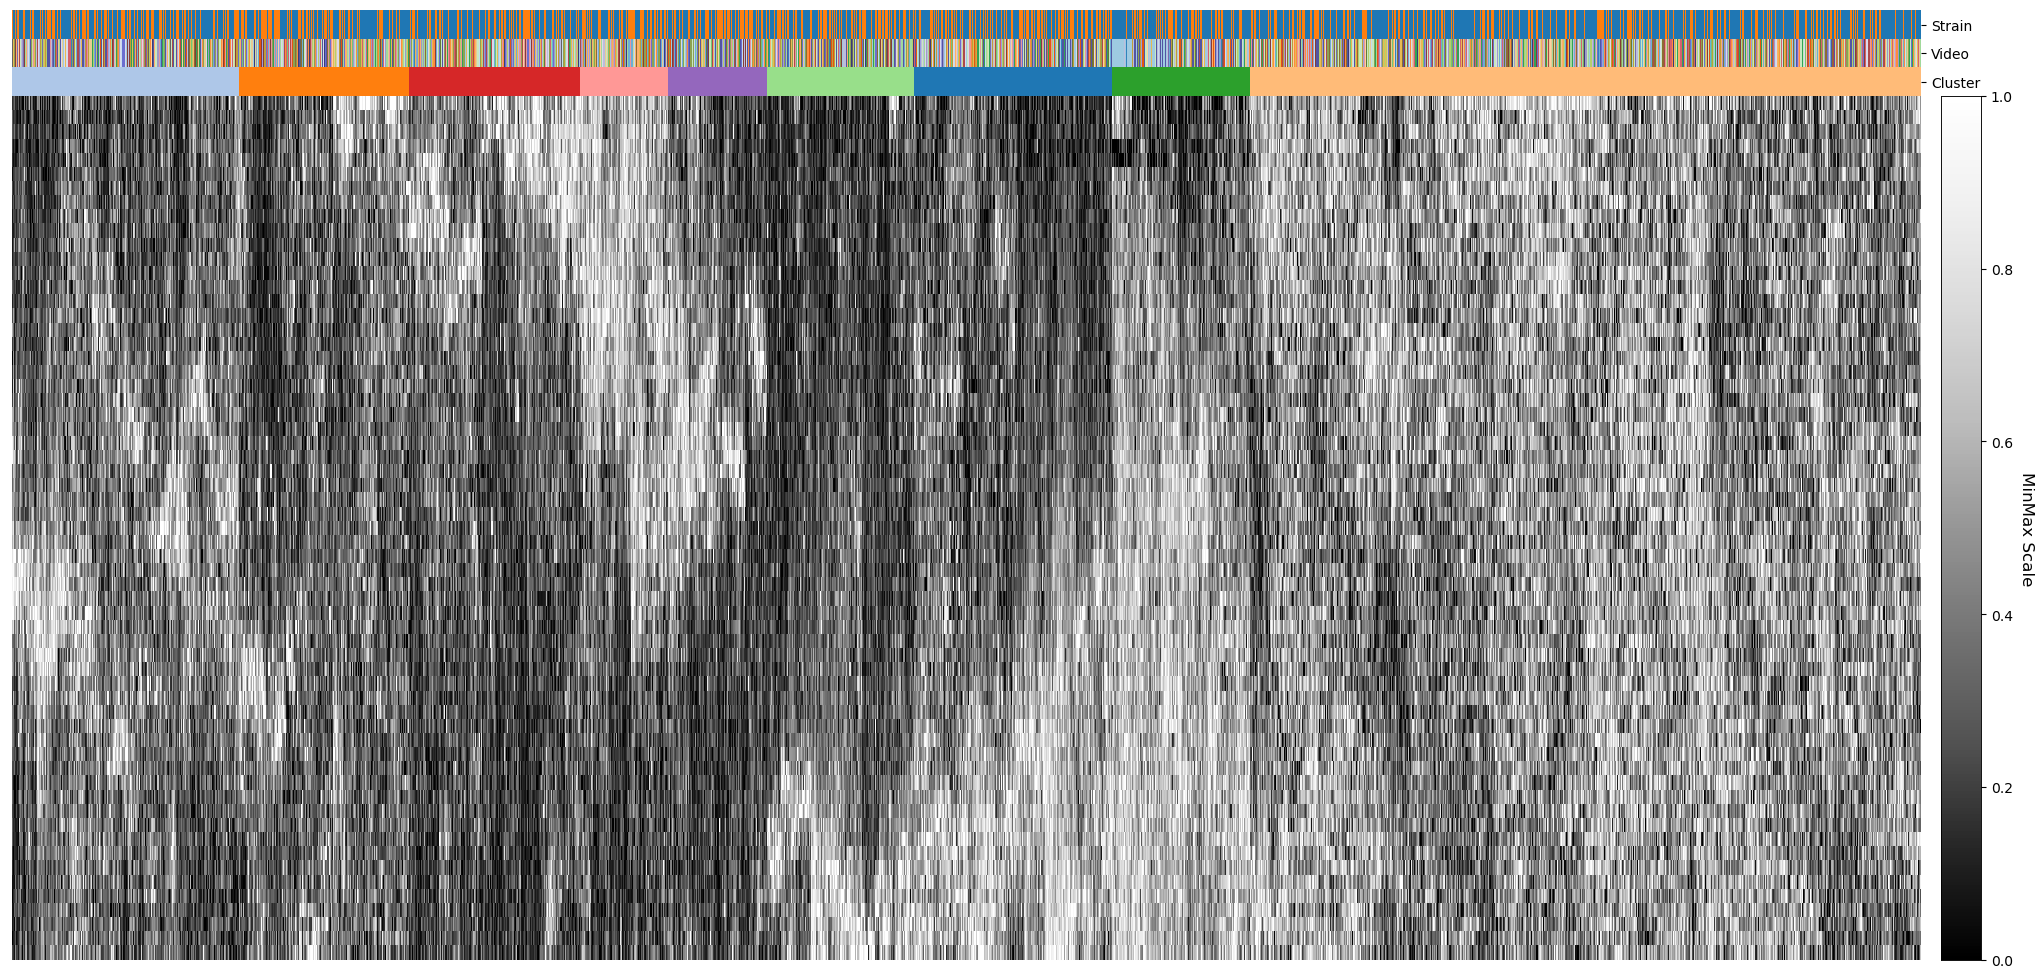

In [13]:
# Call your clusmap function with clustering enabled (this does clustering internally)
g = clusmapscipy(df=data_norm1,
                 dateiname='Data_Cleaning/Clustermap_norm_traces.png',
                 y_label='MinMax Scale', 
                 cluster=True,
                 n_clusters=9)
plt.show()

<h3>2.2 Clustermap Normalized traces with ticks and several outputs</h3>

In [14]:
def clusmapscipy_ticks(
    df: pd.DataFrame,
    dateiname='plot.png',
    output_reordered="Data_Cleaning/reordered_clustermap_output.tsv",
    sep="\t",
    y_label="MinMax scale",
    num_xticks=30,
    cluster=False,
    n_clusters=9,
    hack=False,
    show_ticks=True,
    output_with_clusters="Data_Cleaning/traces_with_clusters_sorted.tsv",
):
    """
    Flexible clustermap generator for MultiIndex DataFrames (label, video, trace).
    Produces reordered dataset and cluster assignments.
    """

    df = df.copy()

    # --- Extract numeric timepoint data ---
    data_numeric = df.select_dtypes(include='float')
    labels = df.index.get_level_values('label')
    videos = df.index.get_level_values('video')

    # --- Consistent strain color palette ---
    label_palette = {'PR8': 'tab:blue', 'X31': 'tab:orange'}
    label_colors = pd.Series(labels).map(lambda x: label_palette.get(x, 'gray'))

    # --- Define video sub-palettes (tab20b/tab20c) ---
    all_videos = pd.Series(videos).unique()
    combined_palette = sns.color_palette("tab20b", len(all_videos) // 2) + \
                       sns.color_palette("tab20c", len(all_videos) - len(all_videos) // 2)
    random.Random(4).shuffle(combined_palette)
    video_palette = dict(zip(all_videos, combined_palette))
    video_colors = pd.Series(videos).map(video_palette)

    # --- Combine colors ---
    col_colors = pd.DataFrame({
        'Strain': label_colors.values,
        'Video': video_colors.values
    }, index=data_numeric.index)

    # --- Optional normalization ---
    if hack:
        data_numeric = data_numeric.apply(min_max, axis=1)

    # --- Perform hierarchical clustering if requested ---
    cluster_colors = None
    clusters = None
    if cluster:
        Z = linkage(data_numeric.values, method='ward', metric='euclidean')
        ll = leaves_list(Z)
        clusters = fcluster(Z, t=n_clusters, criterion='maxclust')[ll]
        data_numeric = data_numeric.iloc[ll]

        clu_pal = sns.color_palette("tab20", n_clusters)
        random.Random(4).shuffle(clu_pal)
        cluster_palette = dict(zip(range(1, n_clusters + 1), clu_pal))
        cluster_colors = pd.Series(clusters, index=data_numeric.index).map(cluster_palette)

        col_colors = col_colors.loc[data_numeric.index]
        col_colors['Cluster'] = cluster_colors

    # --- Create clustermap ---
    g = sns.clustermap(
        data_numeric.T,
        metric='euclidean',
        method='ward',
        figsize=(20, 12),
        row_cluster=False,
        col_cluster=False if cluster else True,
        dendrogram_ratio=(0.001, 0.001),
        col_colors=col_colors,
        cmap="Greys_r",
        yticklabels=False,
        xticklabels=show_ticks
    )

    # --- Adjust colorbar ---
    heatmap_pos = g.ax_heatmap.get_position()
    cbar_width = 0.02
    cbar_x = heatmap_pos.x1 + 0.03
    g.cax.set_position([cbar_x, heatmap_pos.y0, cbar_width, heatmap_pos.height])

    for spine in g.cax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)
        spine.set_visible(True)

    g.cax.set_ylabel(y_label, rotation=270, labelpad=15, fontsize=12)
    g.ax_heatmap.set_xlabel('')

    # --- Manage x tick labels only if enabled ---
    if show_ticks:
        xticks = g.ax_heatmap.get_xticks()
        selected_indices = np.linspace(0, len(xticks) - 1, num=num_xticks, dtype=int)
        reordered_index = data_numeric.index
        tick_labels = [str(df.index.get_loc(idx)) for idx in reordered_index]
        displayed_labels = [tick_labels[i] for i in selected_indices]
        g.ax_heatmap.set_xticks([xticks[i] for i in selected_indices])
        g.ax_heatmap.set_xticklabels(displayed_labels, rotation=90, fontsize=8)
        g.ax_heatmap.tick_params(axis='x', which='both', bottom=True, top=False, length=3, width=0.8, color='black')
    else:
        g.ax_heatmap.set_xticklabels([])
        g.ax_heatmap.set_xticks([])

    # --- Reorder dataset safely ---
    if g.dendrogram_col is not None and hasattr(g.dendrogram_col, "reordered_ind"):
        col_order = g.dendrogram_col.reordered_ind
        reordered_data = df.iloc[col_order, :]
    else:
        reordered_data = df.copy()

    # --- Add cluster assignments and order columns ---
    if cluster and clusters is not None:
        cluster_df = pd.Series(clusters, index=data_numeric.index, name='cluster')
        full_data_sorted = reordered_data.copy()
        full_data_sorted = full_data_sorted.join(cluster_df, how='left')

        # Move 'cluster' column after 'video'
        cols = list(full_data_sorted.columns)
        if 'cluster' in cols:
            cols.remove('cluster')
            if 'video' in cols:
                video_idx = cols.index('video') + 1
                cols.insert(video_idx, 'cluster')
            else:
                cols.insert(0, 'cluster')
            full_data_sorted = full_data_sorted[cols]

        # Sort rows by cluster order (ascending)
        full_data_sorted = full_data_sorted.sort_values(by='cluster', ascending=True)

        # Save ordered output
        full_data_sorted.to_csv(output_with_clusters, sep=sep, index=True)

    # --- Save reordered dataset without cluster column ---
    reordered_data.to_csv(output_reordered, sep=sep, index=True)

    # --- Save the clustermap figure ---
    g.fig.savefig(dateiname, dpi=300, bbox_inches='tight')

    return g, reordered_data, full_data_sorted

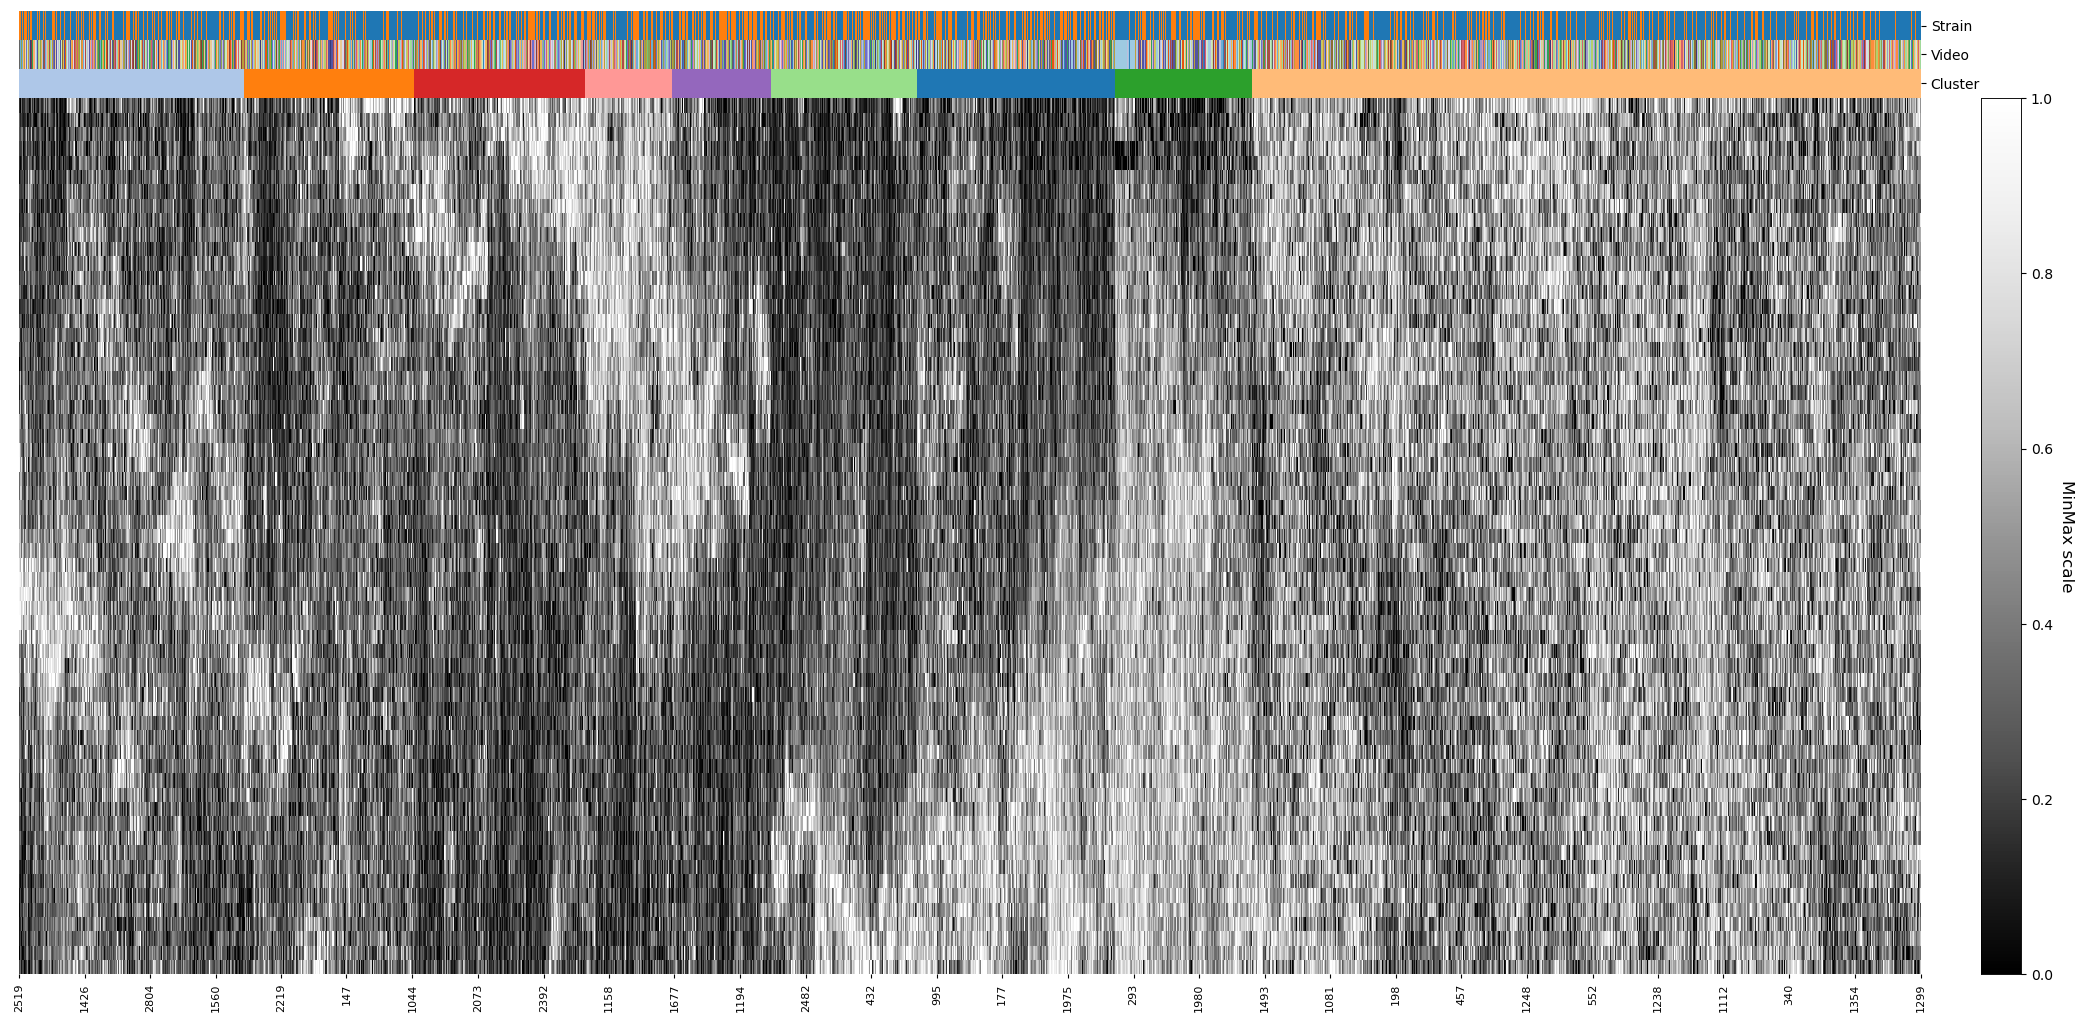

In [15]:
# Run clustermap and get outputs
g, reordered, full_data_sorted = clusmapscipy_ticks(
    df=data_norm1,
    dateiname='Data_Cleaning/Clustermap_norm_traces_ticks.png',
    output_reordered='Data_Cleaning/dataframe_reordered_clustermap_norm.tsv',
    output_with_clusters='Data_Cleaning/dataframe_with_cluster_assignment_norm.tsv',
    cluster=True,
    n_clusters=9,
    hack=False,
    show_ticks=True
)
plt.show()

In [16]:
reordered

time_0   time_10   time_20   time_30   time_40  \
label video    trace                                                         
PR8   PR8_1001 trace_001  0.701169  0.544658  0.565109  0.718698  0.823038   
               trace_002  1.000000  0.612851  0.689305  0.672224  0.904026   
               trace_003  0.507009  0.280082  0.000000  0.444217  0.405666   
               trace_004  0.770064  0.614650  0.614650  0.442675  0.380255   
               trace_005  0.239840  0.162084  0.250092  0.299721  0.292414   
...                            ...       ...       ...       ...       ...   
X31   X31_5003 trace_104  0.766672  0.463055  0.652323  0.748843  0.713184   
               trace_105  0.570880  0.378880  1.000000  0.760000  0.746880   
               trace_106  0.116022  0.060196  0.000000  0.139987  0.037640   
               trace_107  0.189023  0.010757  0.042591  0.260593  0.059495   
               trace_108  0.505195  0.508659  0.790203  0.323107  0.580406   

                           time_50   time_60   time_70   time_80   time_90  \
label video    trace                                                         
PR8   PR8_1001 trace_001  0.834725  0.498331  0.675292  0.695743  0.736227   
               trace_002  0.706385  0.878406  0.901179  0.734445  0.706385   
               trace_003  0.363026  0.397488  0.243575  0.336741  0.336741   
               trace_004  0.743312  0.862420  0.729936  0.871338  0.743312   
               trace_005  0.215025  0.178540  0.271647  0.315809  0.303402   
...                            ...       ...       ...       ...       ...   
X31   X31_5003 trace_104  0.857192  1.000000  0.740442  0.798903  0.535745   
               trace_105  0.946880  0.856000  0.821440  0.682880  0.696000   
               trace_106  0.137027  0.118912  0.273631  0.369564  0.084162   
               trace_107  0.410099  0.345993  0.272887  0.707355  0.592975   
               trace_108  0.405245  0.474023  0.309253  0.714498  0.381494   

                          ...  time_510  time_520  time_530  time_540  \
label video    trace      ...                                           
PR8   PR8_1001 trace_001  ...  0.492487  0.255008  0.289649  0.182387   
               trace_002  ...  0.381456  0.310695  0.593331  0.418056   
               trace_003  ...  0.419977  0.393692  0.251460  0.205023   
               trace_004  ...  0.946497  0.898089  0.451592  0.336306   
               trace_005  ...  1.000000  0.783502  0.558593  0.728353   
...                       ...       ...       ...       ...       ...   
X31   X31_5003 trace_104  ...  0.201269  0.073718  0.304817  0.111949   
               trace_105  ...  0.293440  0.469440  0.445440  0.160000   
               trace_106  ...  0.606471  0.464510  0.345528  0.450342   
               trace_107  ...  0.282108  0.338529  0.320088  0.295719   
               trace_108  ...  0.666502  0.257793  0.072241  0.374567   

                          time_550  time_560  time_570  time_580  time_590  \
label video    trace                                                         
PR8   PR8_1001 trace_001  0.196995  0.373957  0.391068  0.504174  0.159432   
               trace_002  0.508337  0.246035  0.161041  0.432290  0.528264   
               trace_003  0.292056  0.375292  0.113610  0.190713  0.219042   
               trace_004  0.880255  0.513376  0.623567  0.508917  0.734395   
               trace_005  0.749172  0.676147  0.573209  0.314705  0.514799   
...                            ...       ...       ...       ...       ...   
X31   X31_5003 trace_104  0.038059  0.069090  0.140408  0.127379  0.121378   
               trace_105  0.370880  0.221440  0.341440  0.466880  0.218880   
               trace_106  0.280468  0.307888  0.345528  0.360259  0.302953   
               trace_107  0.268277  0.134138  0.106696  0.466520  0.563996   
               trace_108  0.378031  0.704107  0.567046  0.092528  0.000000   

                          time_60

In [17]:
full_data_sorted

cluster    time_0   time_10   time_20   time_30  \
label video    trace                                                        
PR8   PR8_2004 trace_050        1  0.287028  0.383044  0.173647  0.822778   
      PR8_3001 trace_082        1  0.472087  0.724919  0.000000  0.317557   
      PR8_2002 trace_104        1  0.196747  0.225866  0.351522  0.326076   
               trace_105        1  0.000000  0.200755  0.132014  0.083192   
      PR8_1003 trace_094        1  0.462417  0.530606  0.054868  0.149699   
...                           ...       ...       ...       ...       ...   
      PR8_4002 trace_092        9  0.396648  0.685289  0.487275  0.720050   
               trace_091        9  0.448488  0.031779  0.694003  0.562276   
               trace_088        9  0.596811  0.395216  0.968679  0.371298   
      PR8_4003 trace_011        9  0.658762  0.911510  0.871602  0.196645   
X31   X31_5003 trace_108        9  0.505195  0.508659  0.790203  0.323107   

                           time_40   time_50   time_60   time_70   time_80  \
label video    trace                                                         
PR8   PR8_2004 trace_050  0.528090  0.971910  0.457610  0.751788  0.372319   
      PR8_3001 trace_082  0.303398  0.317557  0.407362  0.603964  0.199434   
      PR8_2002 trace_104  0.438877  0.287775  0.431532  0.318730  0.482686   
               trace_105  0.154667  0.219763  0.413227  0.063273  0.142950   
      PR8_1003 trace_094  0.217888  0.277513  0.332382  0.165239  0.389788   
...                            ...       ...       ...       ...       ...   
      PR8_4002 trace_092  0.741775  0.685289  0.741775  0.547486  0.387958   
               trace_091  0.679651  0.587391  0.220400  0.280882  0.274218   
               trace_088  0.830296  0.284738  0.359909  0.790433  0.759112   
      PR8_4003 trace_011  0.413534  0.261423  0.333141  0.550607  1.000000   
X31   X31_5003 trace_108  0.580406  0.405245  0.474023  0.309253  0.714498   

                          ...  time_510  time_520  time_530  time_540  \
label video    trace      ...                                           
PR8   PR8_2004 trace_050  ...  0.432584  0.545965  0.000000  0.287028   
      PR8_3001 trace_082  ...  0.677184  0.680016  0.921521  0.794903   
      PR8_2002 trace_104  ...  0.500787  0.488195  0.081847  0.129328   
               trace_105  ...  0.251400  0.097644  0.103112  0.258560   
      PR8_1003 trace_094  ...  0.499841  0.317158  0.163019  0.000000   
...                       ...       ...       ...       ...       ...   
      PR8_4002 trace_092  ...  0.440099  0.655493  0.651148  0.819367   
               trace_091  ...  0.594567  0.206561  0.078421  0.409021   
               trace_088  ...  0.071185  0.952733  0.339977  0.482346   
      PR8_4003 trace_011  ...  0.369578  0.815500  0.489879  0.546559   
X31   X31_5003 trace_108  ...  0.666502  0.257793  0.072241  0.374567   

                          time_550  time_560  time_570  time_580  time_590  \
label video    trace                                                         
PR8   PR8_2004 trace_050  0.553115  0.528090  0.429009  0.216037  0.609806   
      PR8_3001 trace_082  0.387540  0.278317  0.497168  0.764159  0.853964   
      PR8_2002 trace_104  0.703043  0.542760  0.123820  0.000000  0.089192   
               trace_105  0.165473  0.435881  0.321833  0.234214  0.057024   
      PR8_1003 trace_094  0.392008  0.112274  0.378687  0.394228  0.515382   
...                            ...       ...       ...       ...       ...   
      PR8_4002 trace_092  0.720050  0.737430  0.607697  0.689634  0.655493   
               trace_091  0.604818  0.622758  0.434136  0.540748  0.708355   
               trace_088  0.572893  0.407175  0.596811  0.679954  0.446469   
      PR8_4003 trace_011  0.261423  0.706767  0.590515  0.702718  0.502024   
X31   X31_5003 trace_108  0.378031  0.704107  0.567046  0.092528  0.000000   

                          time_600  
label v

<h4>2.2.1 Subplots for traces from x-ticks</h4>

In [18]:
def subplt(df: pd.DataFrame, dateiname='subplots.png'):
    df = df.copy()
    # Remove "time_" prefix from column names
    df.columns = df.columns.str.replace('time_', '')
    # Convert the column names to integers (if needed)
    df.columns = df.columns.astype(int)
    
    # --- Step 1: Extract displayed x-tick labels from clustermap ---
    displayed_xticklabels = [tick.get_text() for tick in g.ax_heatmap.get_xticklabels() if tick.get_text() != '']
    
    # --- Step 2: Prepare timepoints ---
    timepoints = df.columns.astype(float)
    num_xticks = 7
    xtick_indices = np.linspace(0, len(timepoints) - 1, num=num_xticks, dtype=int)
    xticks = timepoints[xtick_indices]
    xtick_labels = [str(int(t)) if t.is_integer() else f"{t:.1f}" for t in xticks]
    
    # --- Step 3: Create subplots ---
    nrows, ncols = 5, 6  # 30 subplots grid
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, 3 * nrows), sharex=True, sharey=True)
    axs = axs.flatten()
    
    for i, sample_name in enumerate(displayed_xticklabels):
        # Convert sample name to int index if needed
        sample_idx = int(float(sample_name))
        trace = df.iloc[sample_idx]
        label = df.index.get_level_values('label')[sample_idx]
        video = df.index.get_level_values('video')[sample_idx]

        axs[i].plot(timepoints, trace, color='black')
        axs[i].set_title(f"Label: {label} | Video: {video} | Sample: {sample_name}", fontsize=8)
    
        axs[i].set_xticks(xticks)
        axs[i].set_xticklabels(xtick_labels, fontsize=8)
        axs[i].tick_params(axis='y', labelsize=8)
        
        # --- Tick lines ---
        axs[i].tick_params(
            axis='x', which='both',
            bottom=True, top=False,
            length=3, width=0.8, color='black'
        )
        axs[i].tick_params(
            axis='y', which='both',
            left=True, right=False,
            length=3, width=0.8, color='black'
        )

        # --- Remove white space on x-axis ---
        axs[i].set_xlim(timepoints.min(), timepoints.max())
    
    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    # Y-label only on leftmost plots
    for row in range(nrows):
        axs[row * ncols].set_ylabel('MinMax scale [0-1]', fontsize=10)
    
    # X-label only on bottom row
    for col in range(ncols):
        bottom_ax_index = (nrows - 1) * ncols + col
        if bottom_ax_index < len(axs):
            axs[bottom_ax_index].set_xlabel('Time [seconds]', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(dateiname, dpi=300)
    return fig

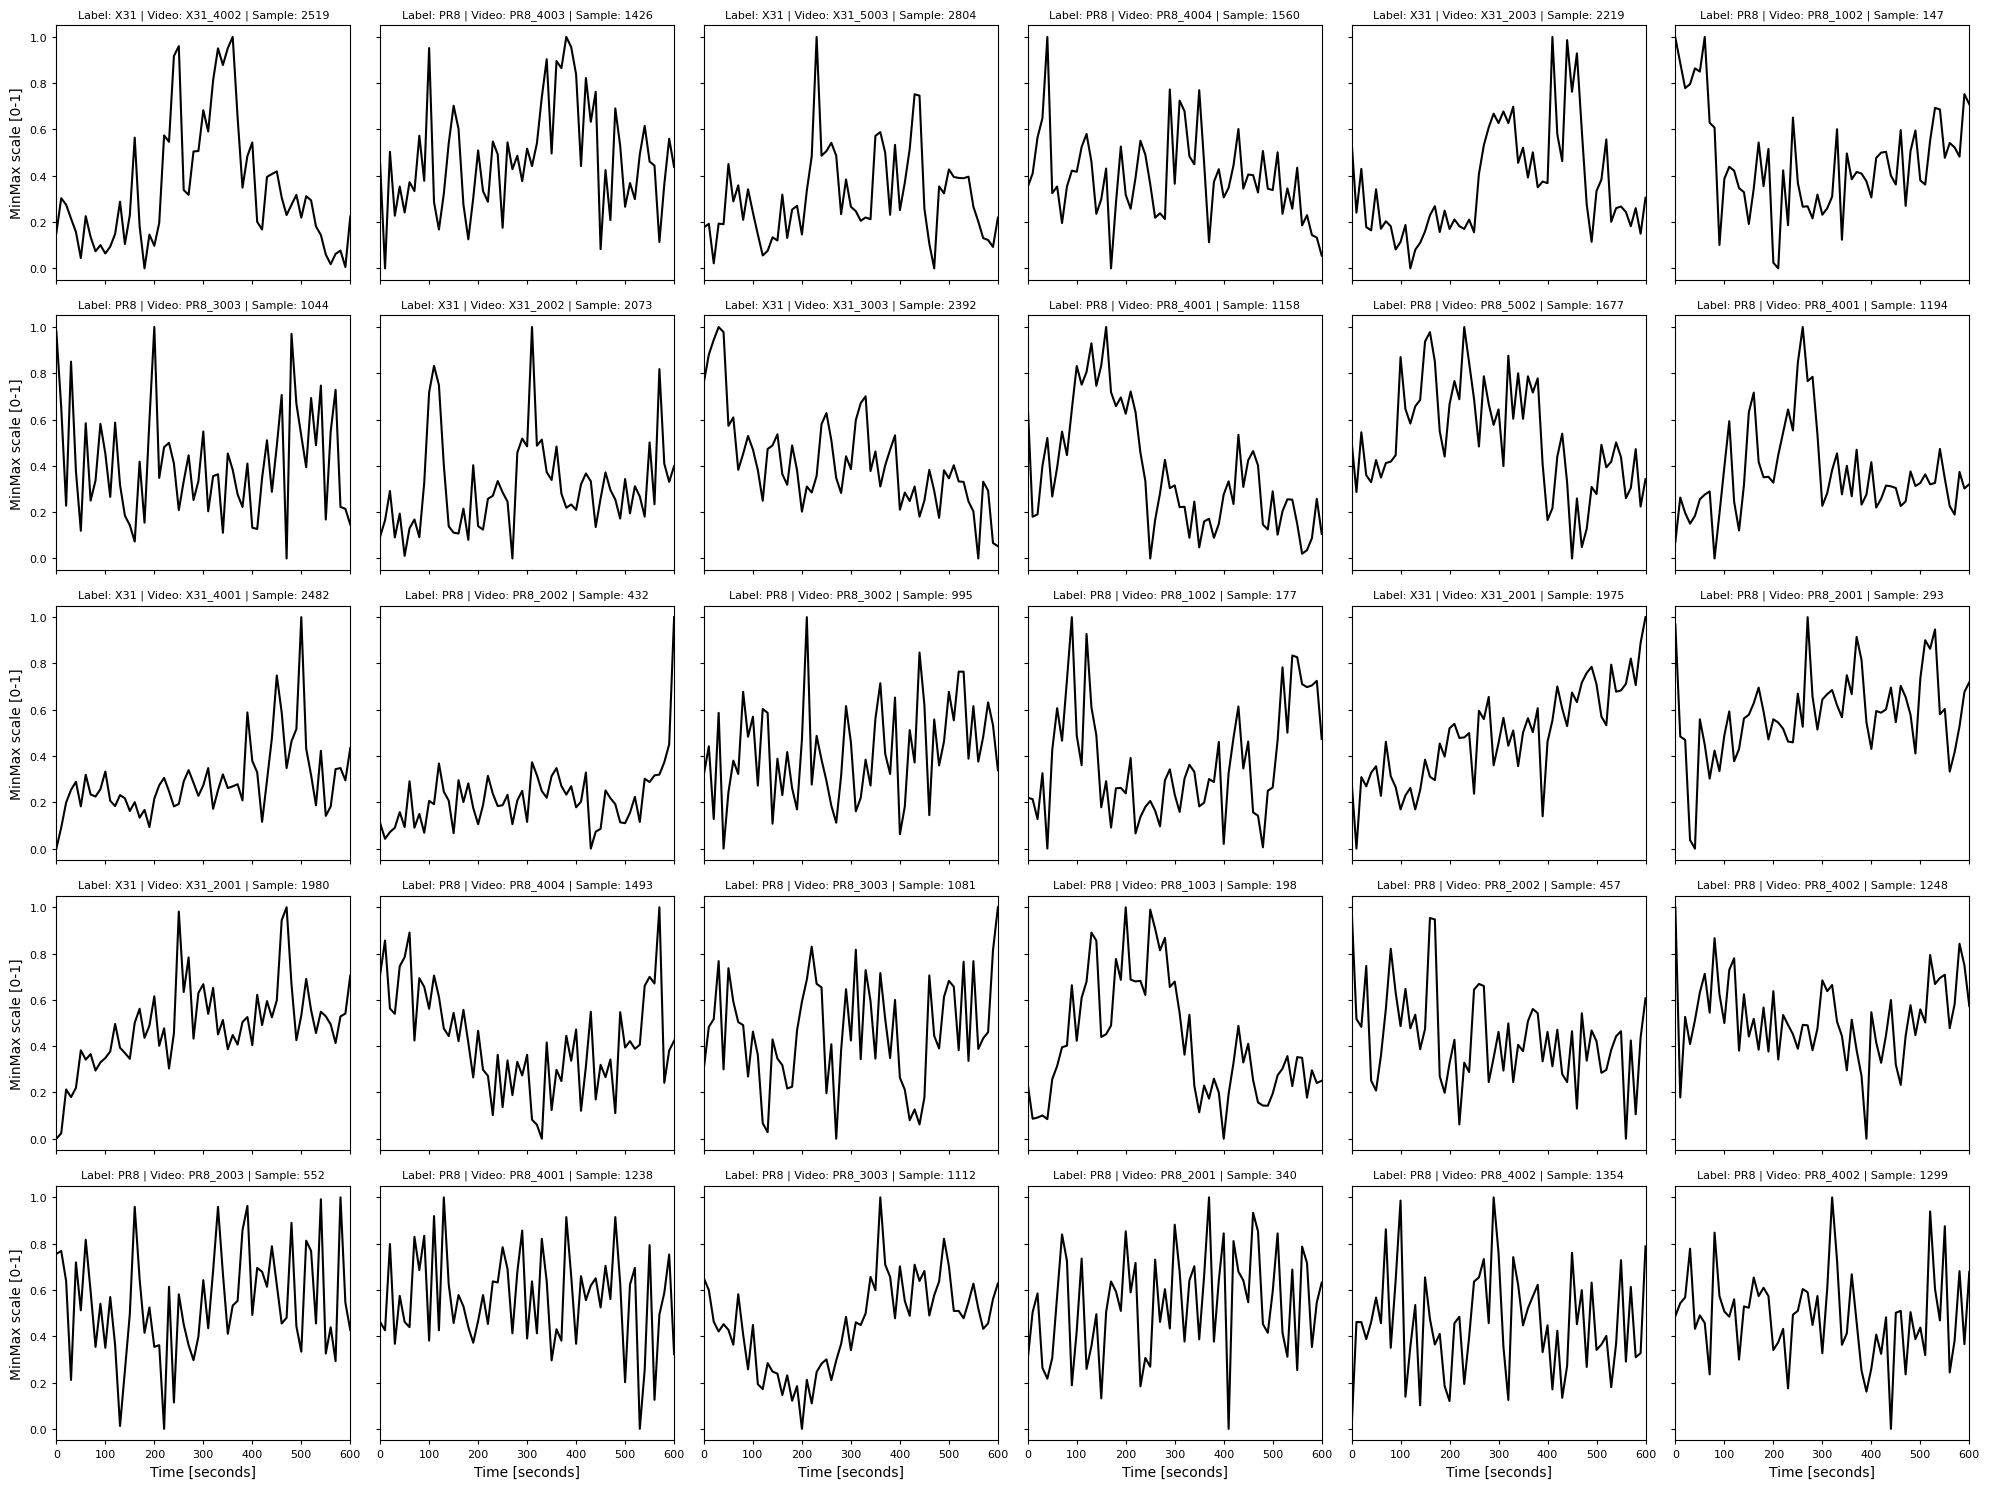

In [19]:
fig = subplt(df=reordered, dateiname='Data_Cleaning/Subplots_reordered_Clustermap_norm.png')
plt.show()

<h4>2.2.2 Scattterplot of cumsum traces with reordered index</h4>

In [20]:
def sctplt(
    df: pd.DataFrame,
    dateiname='scatterplot.png',
    g: sns.matrix.ClusterGrid | None = None
):
    """
    Scatterplot of cumulative sum per sample, matching clustermap order.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame (MultiIndex with 'label', 'video', 'trace').
    dateiname : str
        Output filename for the scatterplot.
    g : sns.matrix.ClusterGrid, optional
        The seaborn clustermap object (to match sample order).
        If provided, the DataFrame will be reordered automatically
        to match the clustermap's column order (g.data2d.columns).

    Returns
    -------
    plt : matplotlib.pyplot
        The resulting matplotlib plot object.
    """

    df = df.copy()

    # --- If clustermap provided, reorder samples to match it ---
    if g is not None and hasattr(g, "data2d"):
        df = df.loc[g.data2d.columns]

    # --- Extract numeric values ---
    data_numeric = df.select_dtypes(include='float')

    # --- Compute cumulative sum per sample ---
    df['cum_sum'] = data_numeric.sum(axis=1)

    # --- Extract label (from MultiIndex) ---
    labels = df.index.get_level_values('label')

    # --- Assign colors based on label ---
    color_map = {'PR8': 'tab:blue', 'X31': 'tab:orange'}
    colors = labels.map(lambda x: color_map.get(x, 'gray'))

    # --- Plot cumulative sums in reordered order ---
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.scatter(range(len(df)), df['cum_sum'], c=colors, s=10)

    ax.set_xlabel('Reordered Sample Index')
    ax.set_xlim(0, len(df))
    ax.set_ylabel('Cumulative Sum')
    ax.set_title('Cumulative Sum of Reordered Samples by Strain')

    # Grid and ticks to display consistently
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(
        axis='x', which='both',
        bottom=True, top=False,
        length=4, width=0.8, color='black'
    )
    ax.tick_params(
        axis='y', which='both',
        left=True, right=False,
        length=4, width=0.8, color='black'
    )

    plt.tight_layout()
    plt.savefig(dateiname, dpi=300)

    return plt

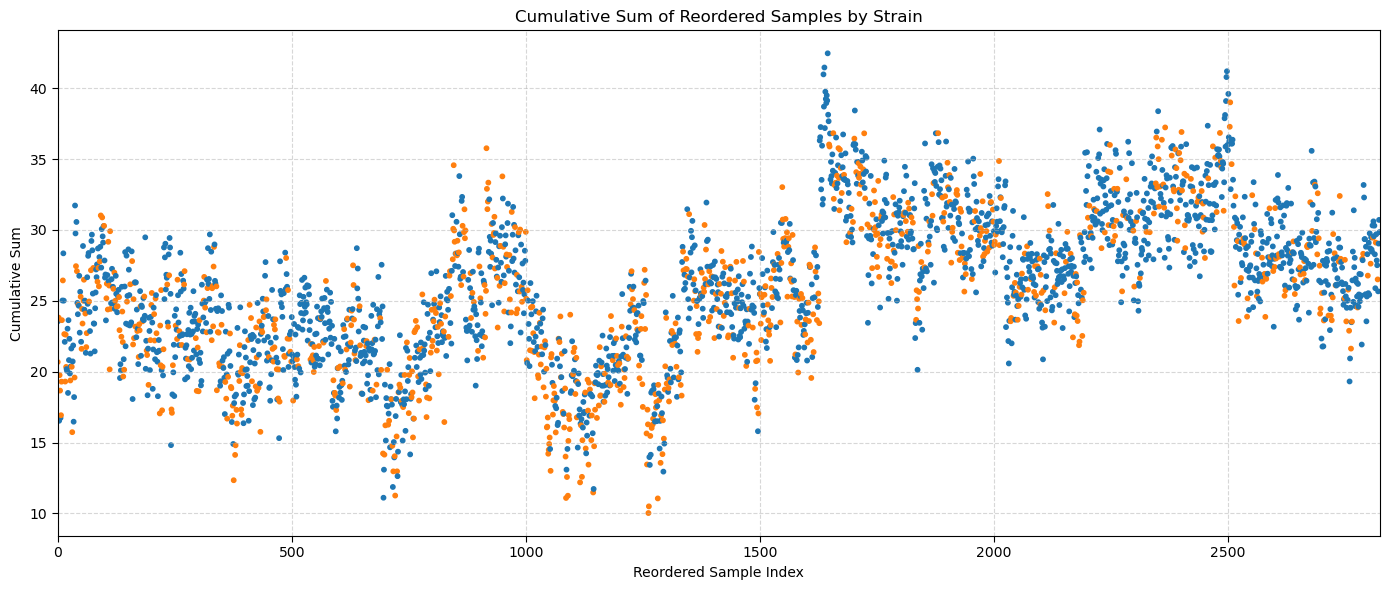

In [21]:
plt = sctplt(
    df=reordered,
    g=g,
    dateiname="Data_Cleaning/Scatterplot_reordered_Clustermap_norm.png"
)
plt.show()

<h3>2.3 Signal-Background Visualization with ECDF</h3>

In [22]:
def plot_ecdf_clusters(
    df: pd.DataFrame,
    dateiname="ECDF_signal_vs_background.png",
    sep="\t",
    signal_clusters=None,
    background_clusters=None,
    signal_color="purple",
    background_color="gold",
    figsize=(5, 4),
    aspect=1.2,
    remove_level=0.5,
):
    """Plot ECDF (Empirical Cumulative Distribution Function) distinguishing Signal vs Background clusters."""
    
    data = df.copy()
    data["cluster"] = pd.to_numeric(data["cluster"], errors="coerce")

    trace_cols = [col for col in data.columns if col.startswith("time_")]
    data["cumsum"] = data[trace_cols].sum(axis=1)

    all_clusters = set(data["cluster"].dropna().unique())
    if background_clusters is not None:
        background_clusters = set(background_clusters)
        signal_clusters = all_clusters - background_clusters
    elif signal_clusters is not None:
        signal_clusters = set(signal_clusters)
        background_clusters = all_clusters - signal_clusters
    else:
        raise ValueError("Specify either signal_clusters or background_clusters.")

    data["group"] = np.where(data["cluster"].isin(signal_clusters), "Signal", "Background")

    def compute_ecdf(values):
        v = np.sort(values)
        y = np.arange(1, len(v) + 1) / len(v)
        return v, y

    x_bg, y_bg = compute_ecdf(data.query('group == "Background"')["cumsum"])
    x_sig, y_sig = compute_ecdf(data.query('group == "Signal"')["cumsum"])

    # --- Cross-point ---
    x_cross = np.interp(remove_level, y_bg, x_bg)

    # Handle non-overlapping ECDFs properly
    if x_cross < x_sig.min():
        y_cross = 0  # no signal traces lost
    elif x_cross > x_sig.max():
        y_cross = 1  # all signal traces lost
    else:
        y_cross = np.interp(x_cross, x_sig, y_sig)

    # --- Plot setup ---
    sns.set_theme(style="white")
    g = sns.displot(
        data=data,
        x="cumsum",
        hue="group",
        kind="ecdf",
        palette={"Signal": signal_color, "Background": background_color},
        height=figsize[0],
        aspect=aspect,
        linewidth=2.2,
    )
    if g._legend is not None:
        g._legend.remove()

    for ax in g.axes.flat:
        ax.axhline(remove_level, color="firebrick", linestyle="--", linewidth=1)
        ax.axvline(x_cross, color="black", linestyle="--", linewidth=1)
        ax.axhline(y_cross, color="green", linestyle="--", linewidth=1)

        # Style
        ax.tick_params(axis='x', which='both', bottom=True, top=False, length=4, width=0.8, color='black')
        ax.tick_params(axis='y', which='both', left=True, right=False, length=4, width=0.8, color='black')

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(0.8)

        all_x = np.concatenate([x_bg, x_sig])
        ax.set_xlim(all_x.min(), all_x.max())
        ax.set_ylim(0, 1)

        # Text
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        ax.text(xlim[1] * 1.02, y_cross, f"{y_cross:.2f}", color="green", va="center", ha="left", fontsize=10, fontweight="bold")
        ax.text(xlim[1] * 1.02, remove_level, f"{remove_level:.2f}", color="firebrick", va="center", ha="left", fontsize=10, fontweight="bold")
        ax.text(x_cross * 1.01, ylim[0] + 0.02 * (ylim[1] - ylim[0]), f"{x_cross:.2f}", color="black", va="bottom", ha="left", fontsize=10, fontweight="bold")

    # --- Legend ---
    remove_pct = remove_level * 100
    lose_pct = 100 - (y_cross * 100)

    if y_cross <= 0:
        lose_label = "lose 0% signal traces (no overlap)"
    elif y_cross >= 1:
        lose_label = "lose 100% signal traces (full overlap)"
    else:
        lose_label = f"lose {lose_pct:.1f}% signal traces"

    handles = [
        Line2D([], [], color=background_color, linewidth=2.5, label="Background"),
        Line2D([], [], color=signal_color, linewidth=2.5, label="Signal"),
        Line2D([], [], color="firebrick", linestyle="--", linewidth=1,
               label=f"remove {remove_pct:.0f}% background traces"),
        Line2D([], [], color="green", linestyle="--", linewidth=1,
               label=lose_label),
    ]
    g.fig.legend(handles=handles, loc="upper left", bbox_to_anchor=(0.92, 1), frameon=False)

    g.set_axis_labels("Cumulative sum", "Proportion")
    g.fig.suptitle("ECDF signal vs. background traces", fontsize=14, y=1.05)
    g.fig.subplots_adjust(right=0.85, top=1)
    g.fig.savefig(dateiname, dpi=300, bbox_inches="tight")
    plt.show()

    return g, x_cross, y_cross

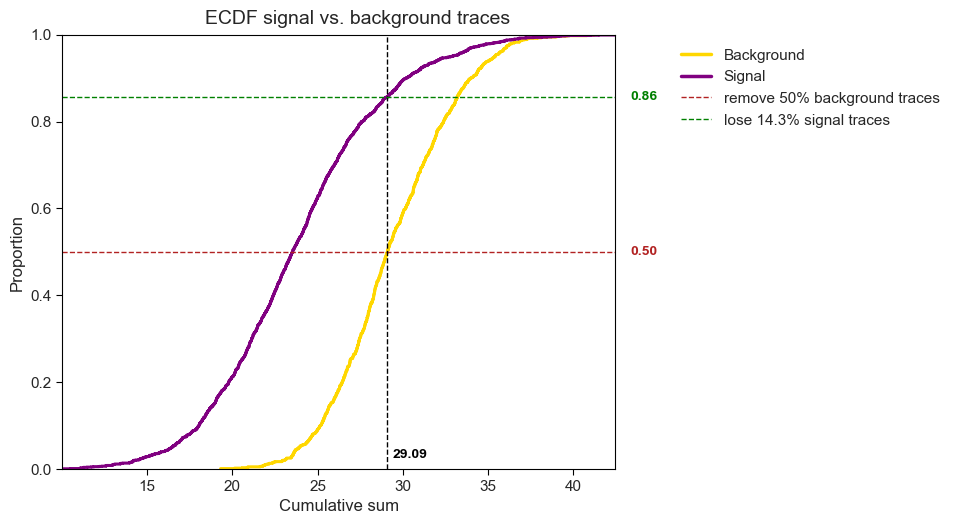

In [23]:
g1, x1, y1 = plot_ecdf_clusters(
    df=full_data_sorted,
    dateiname="Data_Cleaning/ECDF_signal_vs_background_norm.png",
    signal_clusters=range(1, 9)
)

<h4>2.3.1 Deletion of background traces</h4>

In [24]:
def filter_by_cumsum(
    df: pd.DataFrame,
    output_path='without_background.tsv',
    sep="\t",
    threshold=None,
    index_cols=["label", "video", "trace"],
    sum_axis=1,
    verbose=True,
    below_threshold: bool = False,
) -> pd.DataFrame:
    """
    Compute the (row) sum per trace and optionally filter out rows by a threshold.
    Always saves the filtered dataset.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing the trace data.
    output_path : str, optional
        Path to save the filtered dataset.
    sep : str, default="\t"
        Column separator for writing files.
    threshold : float, optional
        Threshold applied to the per-trace sum.
        - If below_threshold is False (default): remove rows with sum > threshold.
        - If below_threshold is True: remove rows with sum < threshold.
    index_cols : list, default=["label", "video", "trace"]
        Columns to set as MultiIndex. (Not used for filtering.)
    sum_axis : int, default=1
        Axis along which to compute the sum (1 = across columns per row).
    verbose : bool, default=True
        Whether to print dataset stats and actions.
    below_threshold : bool, default=False
        If True, delete traces *below* the threshold; otherwise delete *above*.

    Returns
    -------
    pd.DataFrame
        The filtered (or unfiltered) DataFrame.
    """

    data = df.copy()

    # --- Compute per-trace sum across values ---
    data["cumsum"] = data.sum(axis=sum_axis)

    # --- Optionally filter ---
    if threshold is not None:
        before = len(data)
        if below_threshold:
            # keep only rows >= threshold (i.e., delete below)
            data = data[data["cumsum"] >= threshold]
            after = len(data)
            if verbose:
                print(f"Filtered out {before - after} traces below cumsum {threshold:.2f}.")
                print(f"Remaining traces: {after}")
        else:
            # keep only rows <= threshold (i.e., delete above)
            data = data[data["cumsum"] <= threshold]
            after = len(data)
            if verbose:
                print(f"Filtered out {before - after} traces above cumsum {threshold:.2f}.")
                print(f"Remaining traces: {after}")
    else:
        if verbose:
            print("No threshold specified — dataset not filtered.")

    # --- Drop helper column ---
    data = data.drop(columns="cumsum")

    # --- Always save result ---
    data.to_csv(output_path, sep=sep)

    return data

In [25]:
data_imp_background = filter_by_cumsum(
    df=data_norm1,
    output_path="Data_Cleaning/all_traces_norm_without_background.tsv",
    threshold=29.09
)

Filtered out 760 traces above cumsum 29.09.
Remaining traces: 2065


<h2>3. Data Cleaning and data imputation</h2>

<h3>3.1 Data Cleaning</h3>

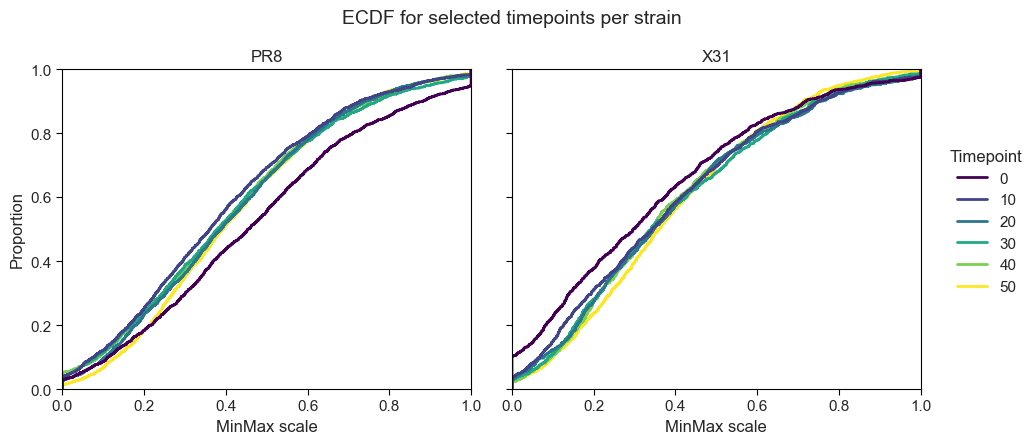

In [26]:
# --- Load and prepare data ---
data_timepoints = pd.read_csv('Exploring_Dataset/all_traces_norm.tsv', sep='\t')

# Identify timepoint columns that start with 'time_'
timepoint_cols = [col for col in data_timepoints.columns if col.startswith('time_')]

# Rename only the timepoint columns to remove 'time_'
new_col_names = {col: int(col.replace('time_', '')) for col in timepoint_cols}
data_timepoints = data_timepoints.rename(columns=new_col_names)

# Make video names unique
data_timepoints['video'] = data_timepoints.apply(lambda s: f'{s.label}_{s.video}', axis=1)

# Set multiindex
data1 = data_timepoints.set_index(['label', 'video', 'trace'])

# Select timepoints (e.g., 0 to 50 in steps of 10)
timepoints = [i for i in range(0, 51, 10)]
timepoints = [tp for tp in timepoints if tp in data1.columns]  # ensure columns exist

# Melt dataframe
df_melted = data1[timepoints].reset_index().melt(
    id_vars=['label', 'video', 'trace'],
    value_vars=timepoints,
    var_name='Timepoint',
    value_name='MinMax scale'
)

# Filter only PR8 and X31
df_filtered = df_melted[df_melted['label'].isin(['PR8', 'X31'])]
df_filtered['Timepoint'] = df_filtered['Timepoint'].astype(int)

# --- Create the ECDF plot ---
sns.set_theme(style="white")
g = sns.displot(
    data=df_filtered,
    kind='ecdf',
    x='MinMax scale',
    hue='Timepoint',
    col='label',
    palette='viridis',
    height=4,
    aspect=1.2,
    linewidth=2.0
)

# --- Style, ticks, and axis limits ---
# Compute overall x-axis range (to remove whitespace)
all_x = df_filtered['MinMax scale'].values
x_min, x_max = all_x.min(), all_x.max()

for ax, label in zip(g.axes.flat, ['PR8', 'X31']):
    # Axis tick styling — only bottom and left ticks
    ax.tick_params(
        axis='x', which='both',
        bottom=True, top=False,
        length=4, width=0.8, color='black'
    )
    ax.tick_params(
        axis='y', which='both',
        left=True, right=False,
        length=4, width=0.8, color='black'
    )

    # Clean black frame
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(0.8)

    # Remove grid
    ax.grid(False)

    # Axis limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1)

    # Simple subplot titles (not bold)
    ax.set_title(label, fontsize=12, fontweight='normal')

# --- Titles and labels ---
g.set_axis_labels("MinMax scale", "Proportion")
g.figure.suptitle(
    "ECDF for selected timepoints per strain",
    y=1.05, fontsize=14
)

# --- Layout: slightly increase spacing between subplots ---
g.figure.subplots_adjust(top=0.9, bottom=0.1, wspace=0.1)

# --- Save and show ---
g.figure.savefig("Data_Cleaning/ECDF_timepoints.png", dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Load raw dataset
data_timepoints = pd.read_csv('../data/all_traces.tsv', sep='\t') # add sep='\t' when dealing with a tsv file instead of a csv file

In [28]:
#delete the first time point (time_0)
delete_first = data_timepoints.drop(columns=['time_0'])
delete_first

label  video      trace  time_10  time_20  time_30  time_40  time_50  \
0      PR8   1001  trace_001  105.319  105.368  105.736  105.986  106.014   
1      PR8   1001  trace_002  104.826  105.014  104.972  105.542  105.056   
2      PR8   1001  trace_003  104.042  103.083  104.604  104.472  104.326   
3      PR8   1001  trace_004  103.062  103.062  102.792  102.694  103.264   
4      PR8   1001  trace_005  115.097  116.771  117.715  117.576  116.104   
...    ...    ...        ...      ...      ...      ...      ...      ...   
2820   X31   5003  trace_104  109.465  110.569  111.132  110.924  111.764   
2821   X31   5003  trace_105  106.892  108.833  108.083  108.042  108.667   
2822   X31   5003  trace_106  113.264  112.410  114.396  112.944  114.354   
2823   X31   5003  trace_107  109.056  109.201  110.194  109.278  110.875   
2824   X31   5003  trace_108  106.056  106.625  105.681  106.201  105.847   

      time_60  time_70  ...  time_510  time_520  time_530  time_540  time_550  \
0     105.208  105.632  ...   105.194   104.625   104.708   104.451   104.486   
1     105.479  105.535  ...   104.257   104.083   104.778   104.347   104.569   
2     104.444  103.917  ...   104.521   104.431   103.944   103.785   104.083   
3     103.451  103.243  ...   103.583   103.507   102.806   102.625   103.479   
4     115.410  117.181  ...   131.035   126.917   122.639   125.868   126.264   
...       ...      ...  ...       ...       ...       ...       ...       ...   
2820  112.597  111.083  ...   107.938   107.194   108.542   107.417   106.986   
2821  108.383  108.275  ...   106.625   107.175   107.100   106.208   106.867   
2822  114.097  116.292  ...   121.014   119.000   117.312   118.799   116.389   
2823  110.583  110.250  ...   110.292   110.549   110.465   110.354   110.229   
2824  105.986  105.653  ...   106.375   105.549   105.174   105.785   105.792   

      time_560  time_570  time_580  time_590  time_600  
0      104.910   104.951   105.222   104.396   104.375  
1      103.924   103.715   104.382   104.618   104.090  
2      104.368   103.472   103.736   103.833   105.097  
3      102.903   103.076   102.896   103.250   103.215  
4      124.875   122.917   118.000   121.806   121.069  
...        ...       ...       ...       ...       ...  
2820   107.167   107.583   107.507   107.472   106.764  
2821   106.400   106.775   107.167   106.392   108.025  
2822   116.778   117.312   117.521   116.708   117.000  
2823   109.618   109.493   111.132   111.576   110.750  
2824   106.451   106.174   105.215   105.028   105.340  

[2825 rows x 63 columns]

In [29]:
delete_first.to_csv('Data_Cleaning/all_traces_raw_deleted_timepoint.tsv', sep='\t', index=False)

<h3>3.2 Data Imputation</h3>

In [30]:
data_imp = pd.read_csv('Data_Cleaning/all_traces_raw_deleted_timepoint.tsv', sep='\t')

In [31]:
# ensure that re-occurring video names do not cause the two classes to mix
data_imp.video = data_imp.apply(lambda s: f'{s.label}_{s.video}', axis=1)
# set a multi-index
data_imp = data_imp.set_index(['label', 'video', 'trace'])
data_imp.head()

time_10  time_20  time_30  time_40  time_50  \
label video    trace                                                    
PR8   PR8_1001 trace_001  105.319  105.368  105.736  105.986  106.014   
               trace_002  104.826  105.014  104.972  105.542  105.056   
               trace_003  104.042  103.083  104.604  104.472  104.326   
               trace_004  103.062  103.062  102.792  102.694  103.264   
               trace_005  115.097  116.771  117.715  117.576  116.104   

                          time_60  time_70  time_80  time_90  time_100  ...  \
label video    trace                                                    ...   
PR8   PR8_1001 trace_001  105.208  105.632  105.681  105.778   105.910  ...   
               trace_002  105.479  105.535  105.125  105.056   104.694  ...   
               trace_003  104.444  103.917  104.236  104.236   104.431  ...   
               trace_004  103.451  103.243  103.465  103.264   103.042  ...   
               trace_005  115.410  117.181  118.021  117.785   116.931  ...   

                          time_510  time_520  time_530  time_540  time_550  \
label video    trace                                                         
PR8   PR8_1001 trace_001   105.194   104.625   104.708   104.451   104.486   
               trace_002   104.257   104.083   104.778   104.347   104.569   
               trace_003   104.521   104.431   103.944   103.785   104.083   
               trace_004   103.583   103.507   102.806   102.625   103.479   
               trace_005   131.035   126.917   122.639   125.868   126.264   

                          time_560  time_570  time_580  time_590  time_600  
label video    trace                                                        
PR8   PR8_1001 trace_001   104.910   104.951   105.222   104.396   104.375  
               trace_002   103.924   103.715   104.382   104.618   104.090  
               trace_003   104.368   103.472   103.736   103.833   105.097  
               trace_004   102.903   103.076   102.896   103.250   103.215  
               trace_005   124.875   122.917   118.000   121.806   121.069  

[5 rows x 60 columns]

In [32]:
data_imp.loc[('PR8', 'PR8_2001'), ['time_30', 'time_40']] = np.nan
data_imp.loc[('PR8', 'PR8_2001')]

time_10  time_20  time_30  time_40  time_50  time_60  time_70  \
trace                                                                      
trace_001  105.444  107.312      NaN      NaN  106.104  104.833  105.444   
trace_002  105.438  106.062      NaN      NaN  105.965  106.715  106.514   
trace_003  104.472  104.840      NaN      NaN  104.590  104.257  105.764   
trace_004  107.535  106.979      NaN      NaN  105.243  106.618  105.875   
trace_005  104.194  104.208      NaN      NaN  104.201  104.076  104.132   
...            ...      ...      ...      ...      ...      ...      ...   
trace_113  103.618  103.910      NaN      NaN  103.556  104.347  104.042   
trace_114  106.896  106.590      NaN      NaN  106.757  106.910  105.653   
trace_115  104.889  105.472      NaN      NaN  104.986  105.312  104.715   
trace_116  102.924  103.069      NaN      NaN  103.278  103.326  103.708   
trace_117  102.569  102.583      NaN      NaN  102.556  103.215  103.472   

           time_80  time_90  time_100  ...  time_510  time_520  time_530  \
trace                                  ...                                 
trace_001  105.257  105.972   105.778  ...   106.222   106.139   106.618   
trace_002  104.806  106.347   105.583  ...   105.903   104.951   105.549   
trace_003  104.854  105.215   105.215  ...   104.701   104.424   105.396   
trace_004  105.986  106.410   105.986  ...   108.854   108.417   107.375   
trace_005  104.507  105.056   104.382  ...   106.285   109.104   106.722   
...            ...      ...       ...  ...       ...       ...       ...   
trace_113  103.674  103.625   103.819  ...   104.340   104.153   104.125   
trace_114  105.299  105.215   104.361  ...   104.590   105.049   104.590   
trace_115  106.000  107.056   107.778  ...   104.847   105.424   105.264   
trace_116  103.389  103.333   103.042  ...   104.035   103.854   102.910   
trace_117  102.625  102.076   102.750  ...   102.493   103.014   103.264   

           time_540  time_550  time_560  time_570  time_580  time_590  \
trace                                                                   
trace_001   107.875   106.493   106.104   106.257   105.528   106.146   
trace_002   105.021   105.750   105.597   105.181   104.694   105.542   
trace_003   105.597   104.861   104.736   104.264   105.285   105.576   
trace_004   107.590   110.701   110.472   108.625   107.507   109.861   
trace_005   106.590   105.757   105.146   105.306   105.653   105.188   
...             ...       ...       ...       ...       ...       ...   
trace_113   104.389   104.507   104.556   104.722   104.479   103.729   
trace_114   107.625   105.958   106.181   105.708   105.340   105.118   
trace_115   105.250   105.500   105.312   105.035   104.951   105.056   
trace_116   103.153   104.069   104.542   104.021   103.431   104.160   
trace_117   102.840   103.035   103.646   102.333   103.028   103.528   

           time_600  
trace                
trace_001   106.028  
trace_002   105.681  
trace_003   105.146  
trace_004   108.208  
trace_005   105.438  
...             ...  
trace_113   104.562  
trace_114   104.792  
trace_115   104.528  
trace_116   104.465  
trace_117   102.479  

[117 rows x 60 columns]

In [33]:
def linear_impute_row(row, cols):
    # extract available timepoints and values
    times = [int(c.split('_')[1]) for c in cols if not pd.isna(row[c])]
    values = [row[c] for c in cols if not pd.isna(row[c])]
    
    # build interpolator
    f = interp1d(times, values, kind='linear', fill_value='extrapolate')
    
    # fill missing values
    for c in cols:
        if pd.isna(row[c]):
            row[c] = float(f(int(c.split('_')[1])))
    return row

# Apply only to rows that have NaN in time_30 or time_40
cols_to_impute = [c for c in data_imp.columns if c.startswith("time_")]
mask = data_imp[['time_30','time_40']].isna().any(axis=1)
data_imp.loc[mask, cols_to_impute] = data_imp.loc[mask, cols_to_impute].apply(
    lambda r: linear_impute_row(r, cols_to_impute), axis=1
)

# round if needed
data_imp[cols_to_impute] = data_imp[cols_to_impute].round(3)

In [34]:
data_imp.loc['PR8', 'PR8_2001']

time_10  time_20  time_30  time_40  time_50  time_60  time_70  \
trace                                                                      
trace_001  105.444  107.312  106.909  106.507  106.104  104.833  105.444   
trace_002  105.438  106.062  106.030  105.997  105.965  106.715  106.514   
trace_003  104.472  104.840  104.757  104.673  104.590  104.257  105.764   
trace_004  107.535  106.979  106.400  105.822  105.243  106.618  105.875   
trace_005  104.194  104.208  104.206  104.203  104.201  104.076  104.132   
...            ...      ...      ...      ...      ...      ...      ...   
trace_113  103.618  103.910  103.792  103.674  103.556  104.347  104.042   
trace_114  106.896  106.590  106.646  106.701  106.757  106.910  105.653   
trace_115  104.889  105.472  105.310  105.148  104.986  105.312  104.715   
trace_116  102.924  103.069  103.139  103.208  103.278  103.326  103.708   
trace_117  102.569  102.583  102.574  102.565  102.556  103.215  103.472   

           time_80  time_90  time_100  ...  time_510  time_520  time_530  \
trace                                  ...                                 
trace_001  105.257  105.972   105.778  ...   106.222   106.139   106.618   
trace_002  104.806  106.347   105.583  ...   105.903   104.951   105.549   
trace_003  104.854  105.215   105.215  ...   104.701   104.424   105.396   
trace_004  105.986  106.410   105.986  ...   108.854   108.417   107.375   
trace_005  104.507  105.056   104.382  ...   106.285   109.104   106.722   
...            ...      ...       ...  ...       ...       ...       ...   
trace_113  103.674  103.625   103.819  ...   104.340   104.153   104.125   
trace_114  105.299  105.215   104.361  ...   104.590   105.049   104.590   
trace_115  106.000  107.056   107.778  ...   104.847   105.424   105.264   
trace_116  103.389  103.333   103.042  ...   104.035   103.854   102.910   
trace_117  102.625  102.076   102.750  ...   102.493   103.014   103.264   

           time_540  time_550  time_560  time_570  time_580  time_590  \
trace                                                                   
trace_001   107.875   106.493   106.104   106.257   105.528   106.146   
trace_002   105.021   105.750   105.597   105.181   104.694   105.542   
trace_003   105.597   104.861   104.736   104.264   105.285   105.576   
trace_004   107.590   110.701   110.472   108.625   107.507   109.861   
trace_005   106.590   105.757   105.146   105.306   105.653   105.188   
...             ...       ...       ...       ...       ...       ...   
trace_113   104.389   104.507   104.556   104.722   104.479   103.729   
trace_114   107.625   105.958   106.181   105.708   105.340   105.118   
trace_115   105.250   105.500   105.312   105.035   104.951   105.056   
trace_116   103.153   104.069   104.542   104.021   103.431   104.160   
trace_117   102.840   103.035   103.646   102.333   103.028   103.528   

           time_600  
trace                
trace_001   106.028  
trace_002   105.681  
trace_003   105.146  
trace_004   108.208  
trace_005   105.438  
...             ...  
trace_113   104.562  
trace_114   104.792  
trace_115   104.528  
trace_116   104.465  
trace_117   102.479  

[117 rows x 60 columns]

In [35]:
data_imp.to_csv('Data_Cleaning/all_traces_raw_imputation.tsv', sep='\t', index=True)

In [36]:
# Normalize the dataset
def min_max(s: pd.Series | pd.DataFrame) -> pd.Series | pd.DataFrame:
    return (s - s.values.min()) / (s.values.max() - s.values.min())

# careful, <pd>.min() and the others have an axis argument and may unexpectedly return series rather than floats. -> use numpy via .values instead or specify axis=None
#help(data.min)
# apply normalization function to each trace
data_norm_imp = data_imp.apply(min_max, axis=1)
# Check to see normalized dataset
#print(data_norm)
# Save the normalized dataset as tsv-file
data_norm_imp.to_csv('Data_Cleaning/all_traces_norm_imputation.tsv', sep='\t', index=True)

In [37]:
data_norm_imp.loc['PR8', 'PR8_2001']

time_10   time_20   time_30   time_40   time_50   time_60  \
trace                                                                   
trace_001  0.315018  0.841364  0.727811  0.614539  0.500986  0.142857   
trace_002  0.512223  0.750573  0.738350  0.725745  0.713522  1.000000   
trace_003  0.107667  0.257749  0.223899  0.189641  0.155791  0.019984   
trace_004  0.419934  0.318065  0.211982  0.106083  0.000000  0.251924   
trace_005  0.023469  0.026253  0.025855  0.025259  0.024861  0.000000   
...             ...       ...       ...       ...       ...       ...   
trace_113  0.244102  0.384689  0.327877  0.271064  0.214251  0.595089   
trace_114  0.771866  0.686630  0.702228  0.717549  0.733148  0.775766   
trace_115  0.086779  0.226923  0.187981  0.149038  0.110096  0.188462   
trace_116  0.174068  0.248086  0.283818  0.319040  0.354773  0.379275   
trace_117  0.316040  0.323452  0.318687  0.313923  0.309158  0.658020   

            time_70   time_80   time_90  time_100  ...  time_510  time_520  \
trace                                              ...                       
trace_001  0.315018  0.262327  0.463793  0.409129  ...  0.534235  0.510848   
trace_002  0.923224  0.270817  0.859435  0.567609  ...  0.689840  0.326203   
trace_003  0.634584  0.263458  0.410685  0.410685  ...  0.201060  0.088091   
trace_004  0.115793  0.136130  0.213815  0.136130  ...  0.661598  0.581532   
trace_005  0.011138  0.085720  0.194909  0.060859  ...  0.439340  1.000000   
...             ...       ...       ...       ...  ...       ...       ...   
trace_113  0.448243  0.271064  0.247472  0.340876  ...  0.591719  0.501685   
trace_114  0.425627  0.327019  0.303621  0.065738  ...  0.129526  0.257382   
trace_115  0.044952  0.353846  0.607692  0.781250  ...  0.076683  0.215385   
trace_116  0.574273  0.411434  0.382848  0.234303  ...  0.741194  0.648800   
trace_117  0.794071  0.345686  0.055056  0.411858  ...  0.275807  0.551615   

           time_530  time_540  time_550  time_560  time_570  time_580  \
trace                                                                   
trace_001  0.645816  1.000000  0.610595  0.500986  0.544097  0.338687   
trace_002  0.554622  0.352941  0.631398  0.572956  0.414057  0.228037   
trace_003  0.484502  0.566476  0.266313  0.215334  0.022838  0.439233   
trace_004  0.390619  0.430011  1.000000  0.958043  0.619641  0.414804   
trace_005  0.526253  0.500000  0.334328  0.212808  0.244630  0.313644   
...             ...       ...       ...       ...       ...       ...   
trace_113  0.488204  0.615311  0.672123  0.695715  0.775638  0.658642   
trace_114  0.129526  0.974930  0.510585  0.572702  0.440947  0.338440   
trace_115  0.176923  0.173558  0.233654  0.188462  0.121875  0.101683   
trace_116  0.166922  0.290965  0.758550  1.000000  0.734048  0.432874   
trace_117  0.683960  0.459502  0.562732  0.886183  0.191106  0.559026   

           time_590  time_600  
trace                          
trace_001  0.512821  0.479572  
trace_002  0.551948  0.605042  
trace_003  0.557912  0.382545  
trace_004  0.846097  0.543239  
trace_005  0.221161  0.270883  
...             ...       ...  
trace_113  0.297545  0.698604  
trace_114  0.276602  0.185794  
trace_115  0.126923  0.000000  
trace_116  0.805003  0.960694  
trace_117  0.823716  0.268396  

[117 rows x 60 columns]

In [38]:
data_norm_imp.loc['PR8', 'PR8_2001']

time_10   time_20   time_30   time_40   time_50   time_60  \
trace                                                                   
trace_001  0.315018  0.841364  0.727811  0.614539  0.500986  0.142857   
trace_002  0.512223  0.750573  0.738350  0.725745  0.713522  1.000000   
trace_003  0.107667  0.257749  0.223899  0.189641  0.155791  0.019984   
trace_004  0.419934  0.318065  0.211982  0.106083  0.000000  0.251924   
trace_005  0.023469  0.026253  0.025855  0.025259  0.024861  0.000000   
...             ...       ...       ...       ...       ...       ...   
trace_113  0.244102  0.384689  0.327877  0.271064  0.214251  0.595089   
trace_114  0.771866  0.686630  0.702228  0.717549  0.733148  0.775766   
trace_115  0.086779  0.226923  0.187981  0.149038  0.110096  0.188462   
trace_116  0.174068  0.248086  0.283818  0.319040  0.354773  0.379275   
trace_117  0.316040  0.323452  0.318687  0.313923  0.309158  0.658020   

            time_70   time_80   time_90  time_100  ...  time_510  time_520  \
trace                                              ...                       
trace_001  0.315018  0.262327  0.463793  0.409129  ...  0.534235  0.510848   
trace_002  0.923224  0.270817  0.859435  0.567609  ...  0.689840  0.326203   
trace_003  0.634584  0.263458  0.410685  0.410685  ...  0.201060  0.088091   
trace_004  0.115793  0.136130  0.213815  0.136130  ...  0.661598  0.581532   
trace_005  0.011138  0.085720  0.194909  0.060859  ...  0.439340  1.000000   
...             ...       ...       ...       ...  ...       ...       ...   
trace_113  0.448243  0.271064  0.247472  0.340876  ...  0.591719  0.501685   
trace_114  0.425627  0.327019  0.303621  0.065738  ...  0.129526  0.257382   
trace_115  0.044952  0.353846  0.607692  0.781250  ...  0.076683  0.215385   
trace_116  0.574273  0.411434  0.382848  0.234303  ...  0.741194  0.648800   
trace_117  0.794071  0.345686  0.055056  0.411858  ...  0.275807  0.551615   

           time_530  time_540  time_550  time_560  time_570  time_580  \
trace                                                                   
trace_001  0.645816  1.000000  0.610595  0.500986  0.544097  0.338687   
trace_002  0.554622  0.352941  0.631398  0.572956  0.414057  0.228037   
trace_003  0.484502  0.566476  0.266313  0.215334  0.022838  0.439233   
trace_004  0.390619  0.430011  1.000000  0.958043  0.619641  0.414804   
trace_005  0.526253  0.500000  0.334328  0.212808  0.244630  0.313644   
...             ...       ...       ...       ...       ...       ...   
trace_113  0.488204  0.615311  0.672123  0.695715  0.775638  0.658642   
trace_114  0.129526  0.974930  0.510585  0.572702  0.440947  0.338440   
trace_115  0.176923  0.173558  0.233654  0.188462  0.121875  0.101683   
trace_116  0.166922  0.290965  0.758550  1.000000  0.734048  0.432874   
trace_117  0.683960  0.459502  0.562732  0.886183  0.191106  0.559026   

           time_590  time_600  
trace                          
trace_001  0.512821  0.479572  
trace_002  0.551948  0.605042  
trace_003  0.557912  0.382545  
trace_004  0.846097  0.543239  
trace_005  0.221161  0.270883  
...             ...       ...  
trace_113  0.297545  0.698604  
trace_114  0.276602  0.185794  
trace_115  0.126923  0.000000  
trace_116  0.805003  0.960694  
trace_117  0.823716  0.268396  

[117 rows x 60 columns]

<h2>4. Explore normalized imputed traces</h2>

In [39]:
# Load raw dataset
data_imputation = pd.read_csv('Data_Cleaning/all_traces_norm_imputation.tsv', sep='\t') # add sep='\t' when dealing with a tsv file instead of a csv file
data_imputation # quick overview of loaded dataset

label     video      trace   time_10   time_20   time_30   time_40  \
0      PR8  PR8_1001  trace_001  0.544658  0.565109  0.718698  0.823038   
1      PR8  PR8_1001  trace_002  0.677913  0.762483  0.743590  1.000000   
2      PR8  PR8_1001  trace_003  0.280082  0.000000  0.444217  0.405666   
3      PR8  PR8_1001  trace_004  0.614650  0.614650  0.442675  0.380255   
4      PR8  PR8_1001  trace_005  0.162084  0.250092  0.299721  0.292414   
...    ...       ...        ...       ...       ...       ...       ...   
2820   X31  X31_5003  trace_104  0.463055  0.652323  0.748843  0.713184   
2821   X31  X31_5003  trace_105  0.378880  1.000000  0.760000  0.746880   
2822   X31  X31_5003  trace_106  0.060196  0.000000  0.139987  0.037640   
2823   X31  X31_5003  trace_107  0.010757  0.042591  0.260593  0.059495   
2824   X31  X31_5003  trace_108  0.508659  0.790203  0.323107  0.580406   

       time_50   time_60   time_70  ...  time_510  time_520  time_530  \
0     0.834725  0.498331  0.675292  ...  0.492487  0.255008  0.289649   
1     0.781377  0.971660  0.996851  ...  0.421952  0.343680  0.656320   
2     0.363026  0.397488  0.243575  ...  0.419977  0.393692  0.251460   
3     0.743312  0.862420  0.729936  ...  0.946497  0.898089  0.451592   
4     0.215025  0.178540  0.271647  ...  1.000000  0.783502  0.558593   
...        ...       ...       ...  ...       ...       ...       ...   
2820  0.857192  1.000000  0.740442  ...  0.201269  0.073718  0.304817   
2821  0.946880  0.856000  0.821440  ...  0.293440  0.469440  0.445440   
2822  0.137027  0.118912  0.273631  ...  0.606471  0.464510  0.345528   
2823  0.410099  0.345993  0.272887  ...  0.282108  0.338529  0.320088   
2824  0.405245  0.474023  0.309253  ...  0.666502  0.257793  0.072241   

      time_540  time_550  time_560  time_570  time_580  time_590  time_600  
0     0.182387  0.196995  0.373957  0.391068  0.504174  0.159432  0.150668  
1     0.462438  0.562303  0.272155  0.178138  0.478183  0.584345  0.346829  
2     0.205023  0.292056  0.375292  0.113610  0.190713  0.219042  0.588201  
3     0.336306  0.880255  0.513376  0.623567  0.508917  0.734395  0.712102  
4     0.728353  0.749172  0.676147  0.573209  0.314705  0.514799  0.476053  
...        ...       ...       ...       ...       ...       ...       ...  
2820  0.111949  0.038059  0.069090  0.140408  0.127379  0.121378  0.000000  
2821  0.160000  0.370880  0.221440  0.341440  0.466880  0.218880  0.741440  
2822  0.450342  0.280468  0.307888  0.345528  0.360259  0.302953  0.323536  
2823  0.295719  0.268277  0.134138  0.106696  0.466520  0.563996  0.382656  
2824  0.374567  0.378031  0.704107  0.567046  0.092528  0.000000  0.154379  

[2825 rows x 63 columns]

In [40]:
# ensure that re-occurring video names do not cause the two classes to mix
#data_imputation.video = data_imputation.apply(lambda s: f'{s.label}_{s.video}', axis=1)
# set a multi-index
data_imputation = data_imputation.set_index(['label', 'video', 'trace'])
data_imputation.head()

time_10   time_20   time_30   time_40   time_50  \
label video    trace                                                         
PR8   PR8_1001 trace_001  0.544658  0.565109  0.718698  0.823038  0.834725   
               trace_002  0.677913  0.762483  0.743590  1.000000  0.781377   
               trace_003  0.280082  0.000000  0.444217  0.405666  0.363026   
               trace_004  0.614650  0.614650  0.442675  0.380255  0.743312   
               trace_005  0.162084  0.250092  0.299721  0.292414  0.215025   

                           time_60   time_70   time_80   time_90  time_100  \
label video    trace                                                         
PR8   PR8_1001 trace_001  0.498331  0.675292  0.695743  0.736227  0.791319   
               trace_002  0.971660  0.996851  0.812416  0.781377  0.618534   
               trace_003  0.397488  0.243575  0.336741  0.336741  0.393692   
               trace_004  0.862420  0.729936  0.871338  0.743312  0.601911   
               trace_005  0.178540  0.271647  0.315809  0.303402  0.258504   

                          ...  time_510  time_520  time_530  time_540  \
label video    trace      ...                                           
PR8   PR8_1001 trace_001  ...  0.492487  0.255008  0.289649  0.182387   
               trace_002  ...  0.421952  0.343680  0.656320  0.462438   
               trace_003  ...  0.419977  0.393692  0.251460  0.205023   
               trace_004  ...  0.946497  0.898089  0.451592  0.336306   
               trace_005  ...  1.000000  0.783502  0.558593  0.728353   

                          time_550  time_560  time_570  time_580  time_590  \
label video    trace                                                         
PR8   PR8_1001 trace_001  0.196995  0.373957  0.391068  0.504174  0.159432   
               trace_002  0.562303  0.272155  0.178138  0.478183  0.584345   
               trace_003  0.292056  0.375292  0.113610  0.190713  0.219042   
               trace_004  0.880255  0.513376  0.623567  0.508917  0.734395   
               trace_005  0.749172  0.676147  0.573209  0.314705  0.514799   

                          time_600  
label video    trace                
PR8   PR8_1001 trace_001  0.150668  
               trace_002  0.346829  
               trace_003  0.588201  
               trace_004  0.712102  
               trace_005  0.476053  

[5 rows x 60 columns]

<h3>4.1 Heatmap normalized imputed traces</h3>

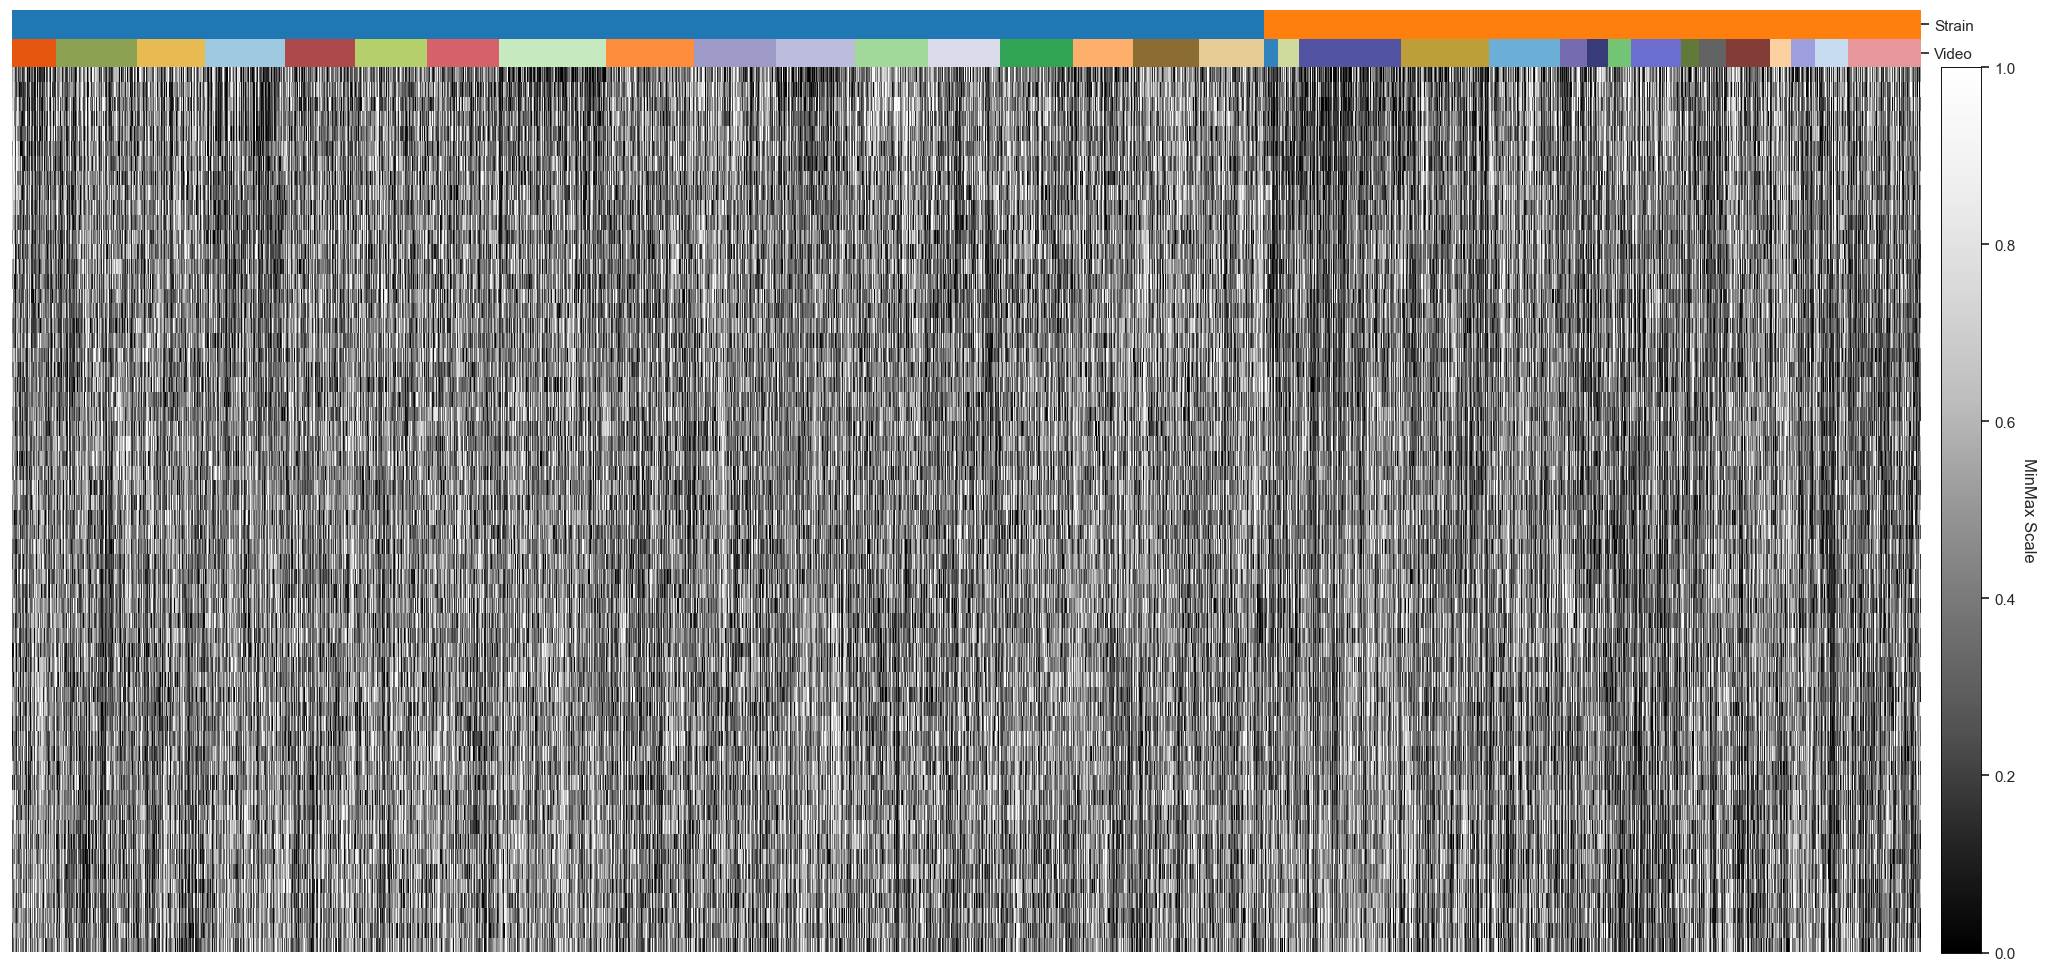

In [41]:
# Clustermap mit clustering
g = clusmapsns(df=data_imputation, dateiname='Data_Cleaning/Heatmap_norm_traces_imputation.png', y_label='MinMax Scale', cluster=False)
# Show and save
plt.show()

<h3>4.2 Clustermap normalized imputed traces</h3>

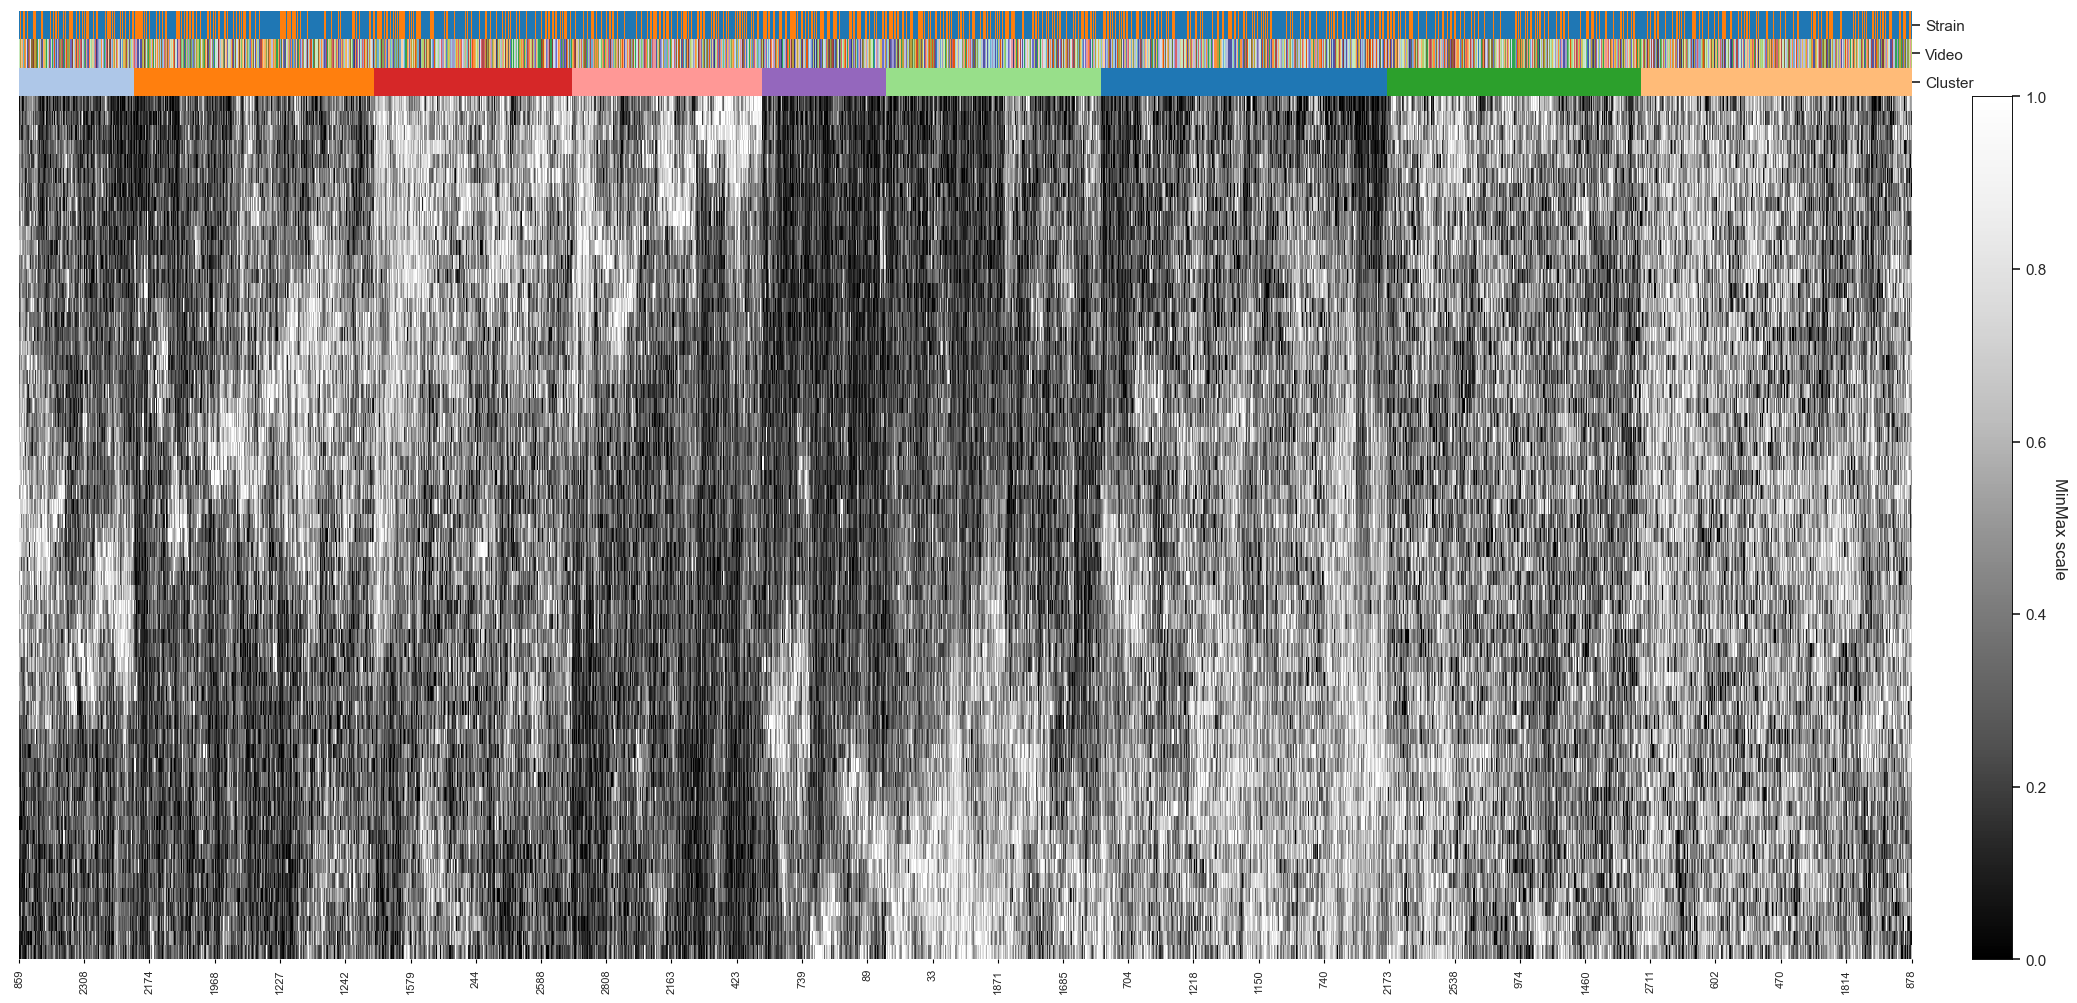

In [42]:
g, reordered, full_data_sorted = clusmapscipy_ticks(
    df=data_imputation,
    dateiname='Data_Cleaning/Clustermap_norm_traces_imputation_ticks.png',
    output_reordered='Data_Cleaning/dataframe_reordered_clustermap_norm_imp.tsv',
    output_with_clusters='Data_Cleaning/dataframe_with_cluster_assignment_norm_imp.tsv',
    cluster=True,         # enables clustering
    n_clusters=9,         # number of clusters
    hack=False,           # enable min–max normalization if you want
    show_ticks=True       # shows numeric indices as tick labels
)
plt.show()

<h3>4.3 Subplots normalized imputed traces</h3>

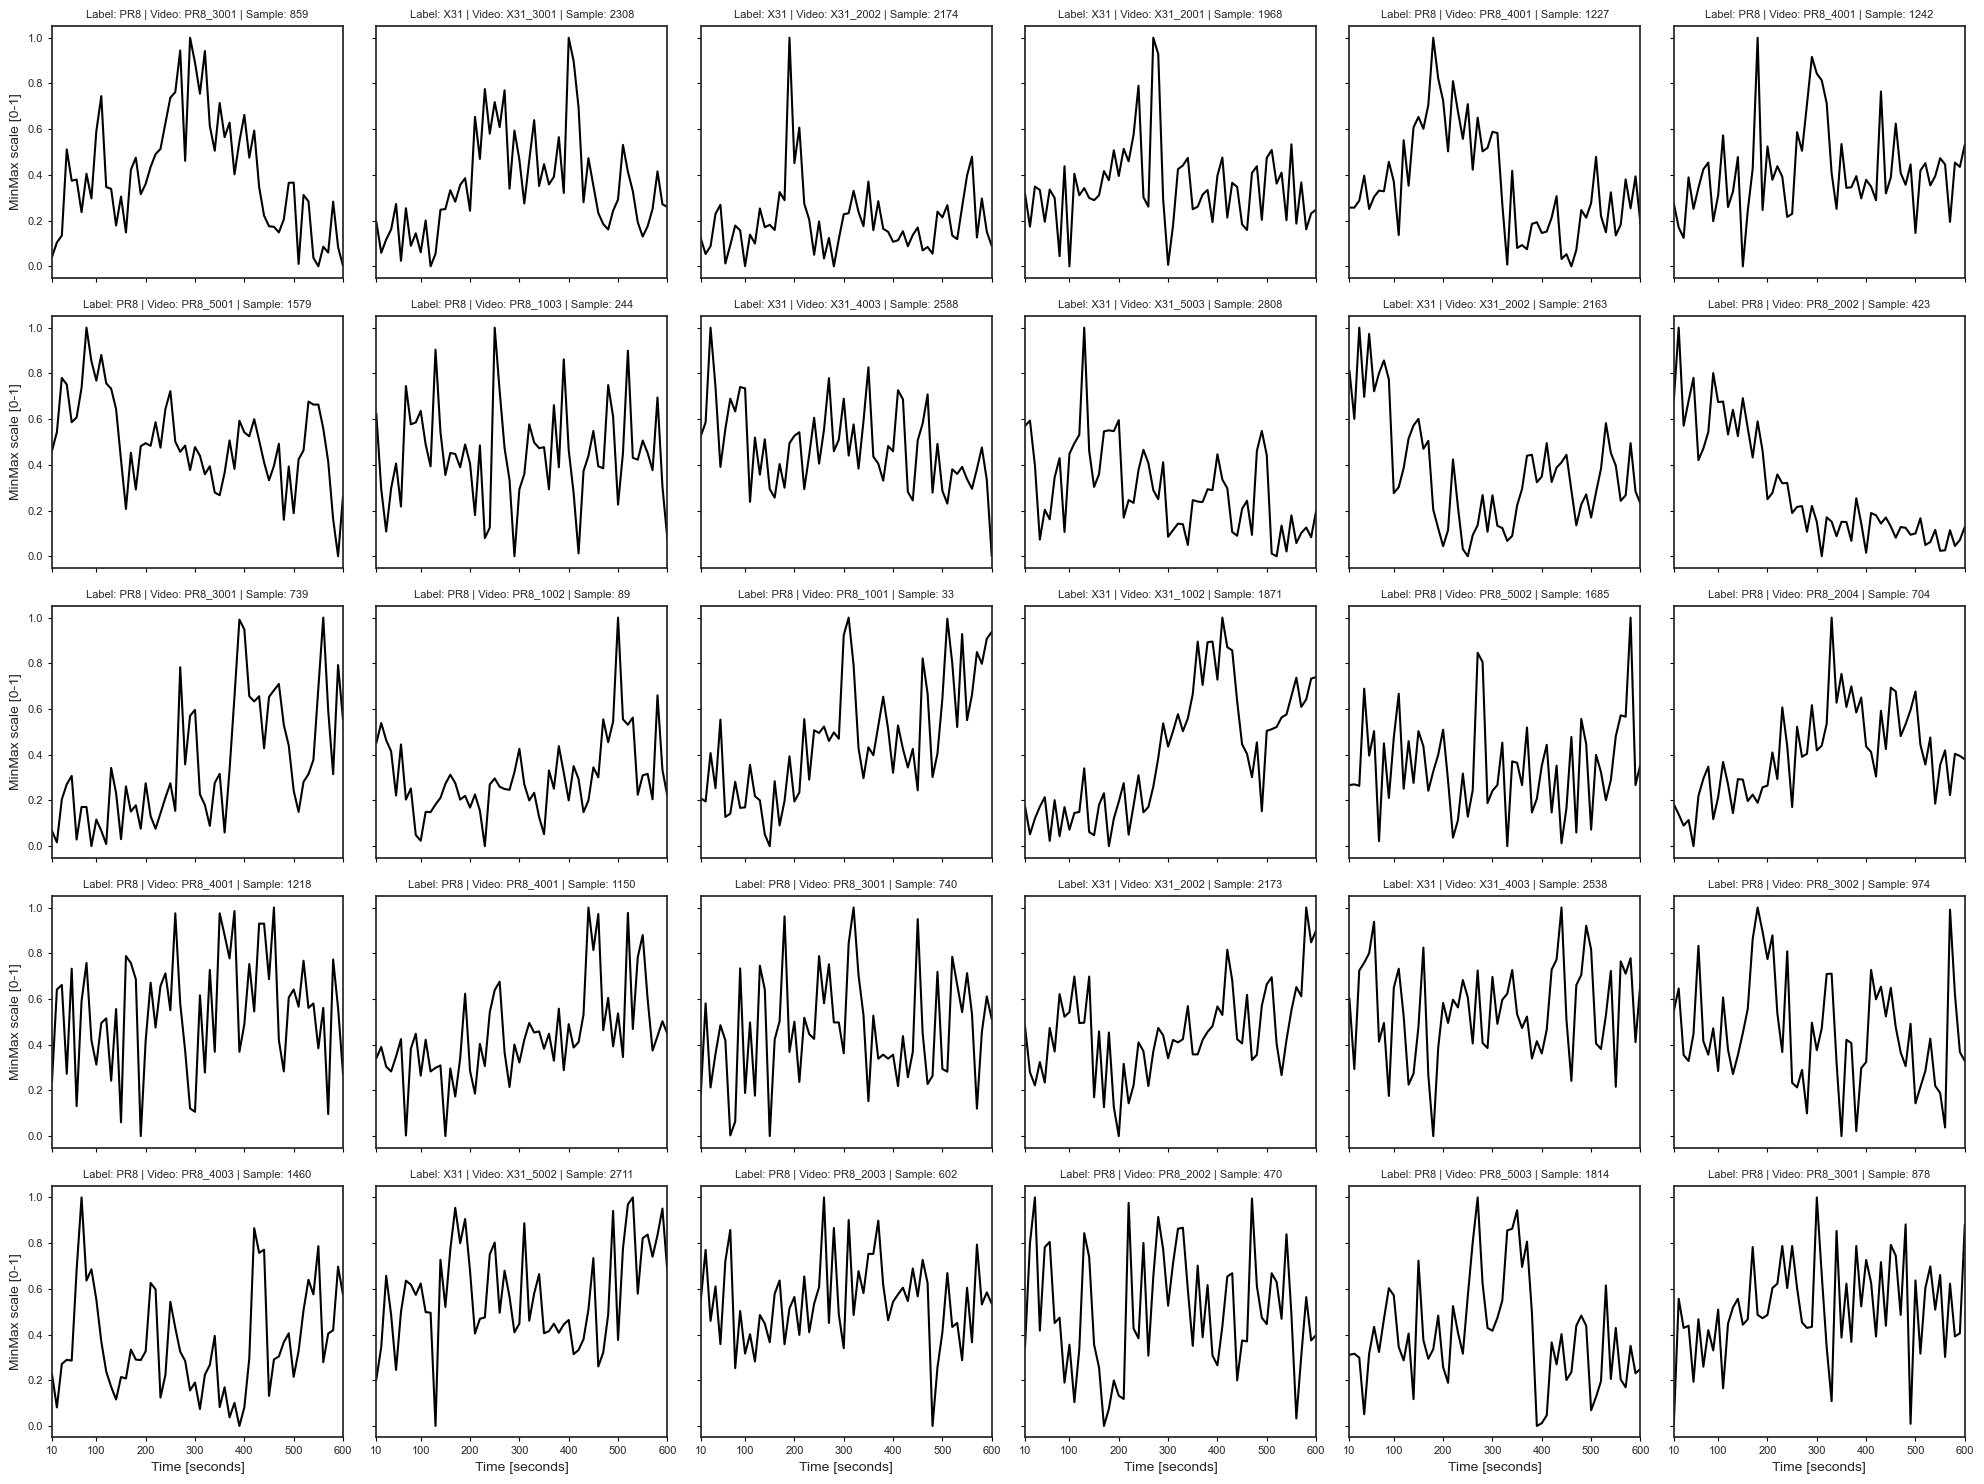

In [43]:
fig= subplt(df=reordered, dateiname='Data_Cleaning/Subplots_reordered_Clustermap_norm_imp.png')
plt.show()

<h3>4.4 Scatterplot normalized imputed traces</h3>

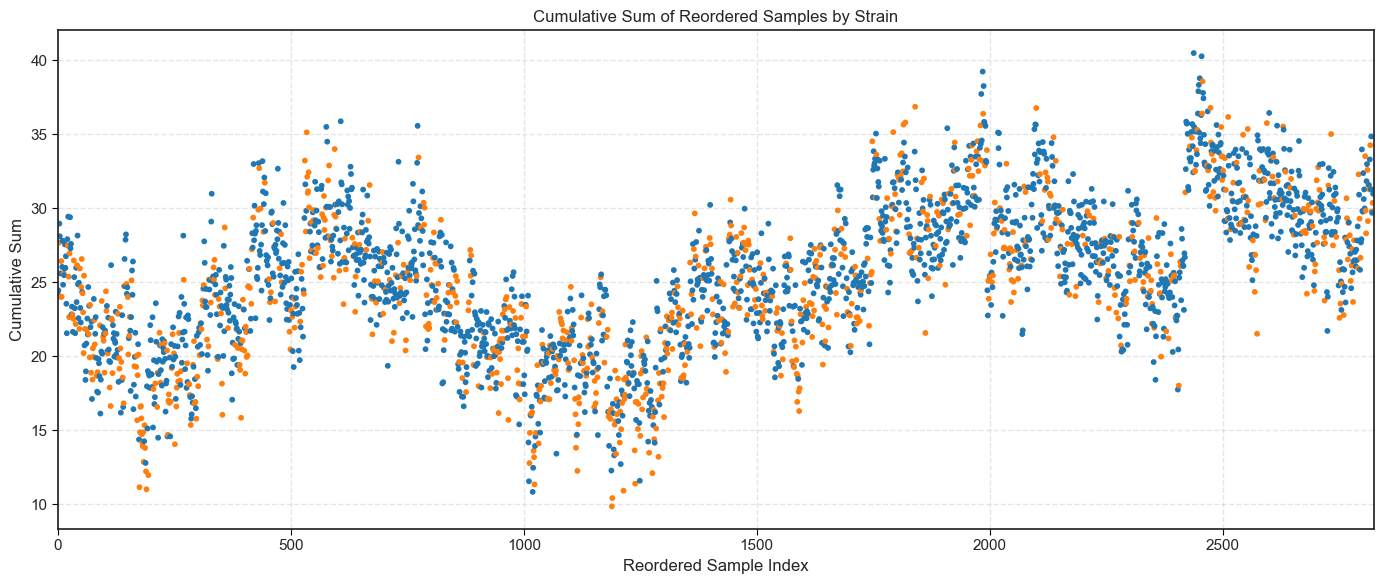

In [44]:
plt=sctplt(df=reordered,
           g=g,
           dateiname="Data_Cleaning/Scatterplot_reordered_Clustermap_norm_imp.png")
plt.show()

<h3>4.5 Signal-Background visualization normalized imputed traces</h3>

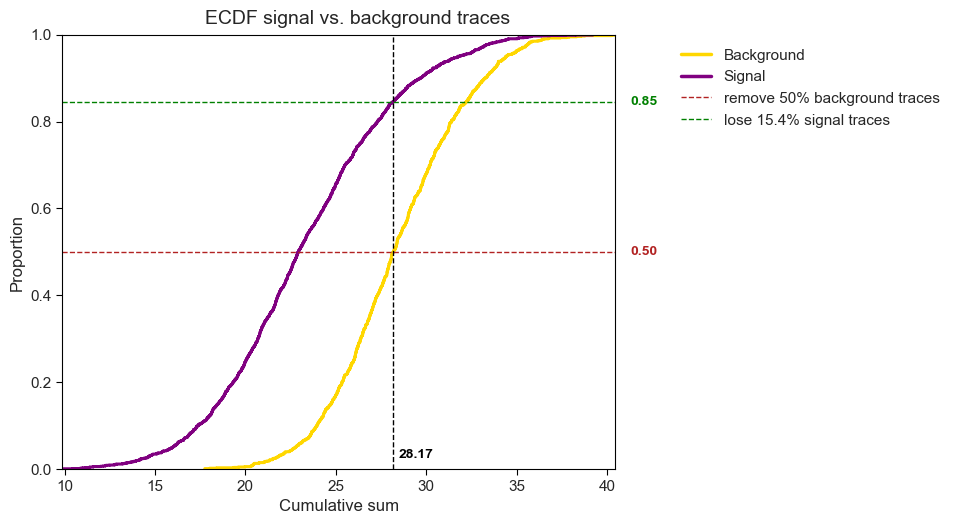

In [45]:
g2, x2, y2 = plot_ecdf_clusters(
    df=full_data_sorted,
    dateiname="Data_Cleaning/ECDF_signal_vs_background_norm_imp.png",
    signal_clusters={1, 2, 4, 5, 6, 7}
)

<h3>4.6 Deletion Background traces for normalized imputed dataset</h3>

In [46]:
data_imp_background = filter_by_cumsum(
    df=data_imputation,
    output_path="Data_Cleaning/all_traces_norm_imputation_without_background.tsv",
    threshold=28.17
)

Filtered out 809 traces above cumsum 28.17.
Remaining traces: 2016


<h2>5. Normalize dataset by video</h2>

<h3>5.1 Normalization of raw imputed/cleaned dataset</h3>

In [47]:
# Load raw dataset
data_video = pd.read_csv('Data_Cleaning/all_traces_raw_imputation.tsv', sep='\t') # add sep='\t' when dealing with a tsv file instead of a csv file
data_video # quick overview of loaded dataset

label     video      trace  time_10  time_20  time_30  time_40  time_50  \
0      PR8  PR8_1001  trace_001  105.319  105.368  105.736  105.986  106.014   
1      PR8  PR8_1001  trace_002  104.826  105.014  104.972  105.542  105.056   
2      PR8  PR8_1001  trace_003  104.042  103.083  104.604  104.472  104.326   
3      PR8  PR8_1001  trace_004  103.062  103.062  102.792  102.694  103.264   
4      PR8  PR8_1001  trace_005  115.097  116.771  117.715  117.576  116.104   
...    ...       ...        ...      ...      ...      ...      ...      ...   
2820   X31  X31_5003  trace_104  109.465  110.569  111.132  110.924  111.764   
2821   X31  X31_5003  trace_105  106.892  108.833  108.083  108.042  108.667   
2822   X31  X31_5003  trace_106  113.264  112.410  114.396  112.944  114.354   
2823   X31  X31_5003  trace_107  109.056  109.201  110.194  109.278  110.875   
2824   X31  X31_5003  trace_108  106.056  106.625  105.681  106.201  105.847   

      time_60  time_70  ...  time_510  time_520  time_530  time_540  time_550  \
0     105.208  105.632  ...   105.194   104.625   104.708   104.451   104.486   
1     105.479  105.535  ...   104.257   104.083   104.778   104.347   104.569   
2     104.444  103.917  ...   104.521   104.431   103.944   103.785   104.083   
3     103.451  103.243  ...   103.583   103.507   102.806   102.625   103.479   
4     115.410  117.181  ...   131.035   126.917   122.639   125.868   126.264   
...       ...      ...  ...       ...       ...       ...       ...       ...   
2820  112.597  111.083  ...   107.938   107.194   108.542   107.417   106.986   
2821  108.383  108.275  ...   106.625   107.175   107.100   106.208   106.867   
2822  114.097  116.292  ...   121.014   119.000   117.312   118.799   116.389   
2823  110.583  110.250  ...   110.292   110.549   110.465   110.354   110.229   
2824  105.986  105.653  ...   106.375   105.549   105.174   105.785   105.792   

      time_560  time_570  time_580  time_590  time_600  
0      104.910   104.951   105.222   104.396   104.375  
1      103.924   103.715   104.382   104.618   104.090  
2      104.368   103.472   103.736   103.833   105.097  
3      102.903   103.076   102.896   103.250   103.215  
4      124.875   122.917   118.000   121.806   121.069  
...        ...       ...       ...       ...       ...  
2820   107.167   107.583   107.507   107.472   106.764  
2821   106.400   106.775   107.167   106.392   108.025  
2822   116.778   117.312   117.521   116.708   117.000  
2823   109.618   109.493   111.132   111.576   110.750  
2824   106.451   106.174   105.215   105.028   105.340  

[2825 rows x 63 columns]

In [48]:
# data imputation
# ensure that re-occurring video names do not cause the two classes to mix
#data_video.video = data_video.apply(lambda s: f'{s.label}_{s.video}', axis=1)
# set a multi-index
data_video = data_video.set_index(['label', 'video', 'trace'])
data_video.head()

time_10  time_20  time_30  time_40  time_50  \
label video    trace                                                    
PR8   PR8_1001 trace_001  105.319  105.368  105.736  105.986  106.014   
               trace_002  104.826  105.014  104.972  105.542  105.056   
               trace_003  104.042  103.083  104.604  104.472  104.326   
               trace_004  103.062  103.062  102.792  102.694  103.264   
               trace_005  115.097  116.771  117.715  117.576  116.104   

                          time_60  time_70  time_80  time_90  time_100  ...  \
label video    trace                                                    ...   
PR8   PR8_1001 trace_001  105.208  105.632  105.681  105.778   105.910  ...   
               trace_002  105.479  105.535  105.125  105.056   104.694  ...   
               trace_003  104.444  103.917  104.236  104.236   104.431  ...   
               trace_004  103.451  103.243  103.465  103.264   103.042  ...   
               trace_005  115.410  117.181  118.021  117.785   116.931  ...   

                          time_510  time_520  time_530  time_540  time_550  \
label video    trace                                                         
PR8   PR8_1001 trace_001   105.194   104.625   104.708   104.451   104.486   
               trace_002   104.257   104.083   104.778   104.347   104.569   
               trace_003   104.521   104.431   103.944   103.785   104.083   
               trace_004   103.583   103.507   102.806   102.625   103.479   
               trace_005   131.035   126.917   122.639   125.868   126.264   

                          time_560  time_570  time_580  time_590  time_600  
label video    trace                                                        
PR8   PR8_1001 trace_001   104.910   104.951   105.222   104.396   104.375  
               trace_002   103.924   103.715   104.382   104.618   104.090  
               trace_003   104.368   103.472   103.736   103.833   105.097  
               trace_004   102.903   103.076   102.896   103.250   103.215  
               trace_005   124.875   122.917   118.000   121.806   121.069  

[5 rows x 60 columns]

In [49]:
# Load dataset
#data_video = pd.read_csv('Data_Cleaning/all_traces_raw_imputation_norm_video.tsv', sep='\t')

# Identify time columns
time_cols = [col for col in data_video.columns if col.startswith('time_')]

def normalize_with_multiple_minmax(df: pd.DataFrame) -> pd.DataFrame:
    def normalize_group(group: pd.DataFrame) -> pd.DataFrame:
        # Work on a copy (to avoid SettingWithCopyWarning)
        group = group.copy()
        values = group[time_cols].to_numpy()
        flat_values = values.flatten()

        global_min = flat_values.min()
        global_max = flat_values.max()

        if np.isclose(global_min, global_max):
            norm = np.zeros_like(values)
        else:
            norm = (values - global_min) / (global_max - global_min)

            # Explicitly assign 0s and 1s to min/max
            min_mask = np.isclose(values, global_min)
            max_mask = np.isclose(values, global_max)
            norm[min_mask] = 0.0
            norm[max_mask] = 1.0

        group[time_cols] = norm
        return group

    # Group by index levels "label" and "video"
    return df.groupby(level=["label", "video"], group_keys=False).apply(normalize_group)

# Apply normalization
data_norm_video = normalize_with_multiple_minmax(data_video.copy())

# Validate
values = data_norm_video[time_cols].values
zero_count = np.isclose(values, 0.0).sum()
one_count = np.isclose(values, 1.0).sum()
group_count = data_video.groupby(['label', 'video']).ngroups

print(f"\n Found {zero_count} 0s")
print(f" Found {one_count} 1s")

# Save result
data_norm_video.to_csv('Data_Cleaning/all_traces_norm_by_label_video.tsv', sep='\t', index=True)


 Found 34 0s
 Found 34 1s


<h3>5.2 Heatmap norm by video</h3>

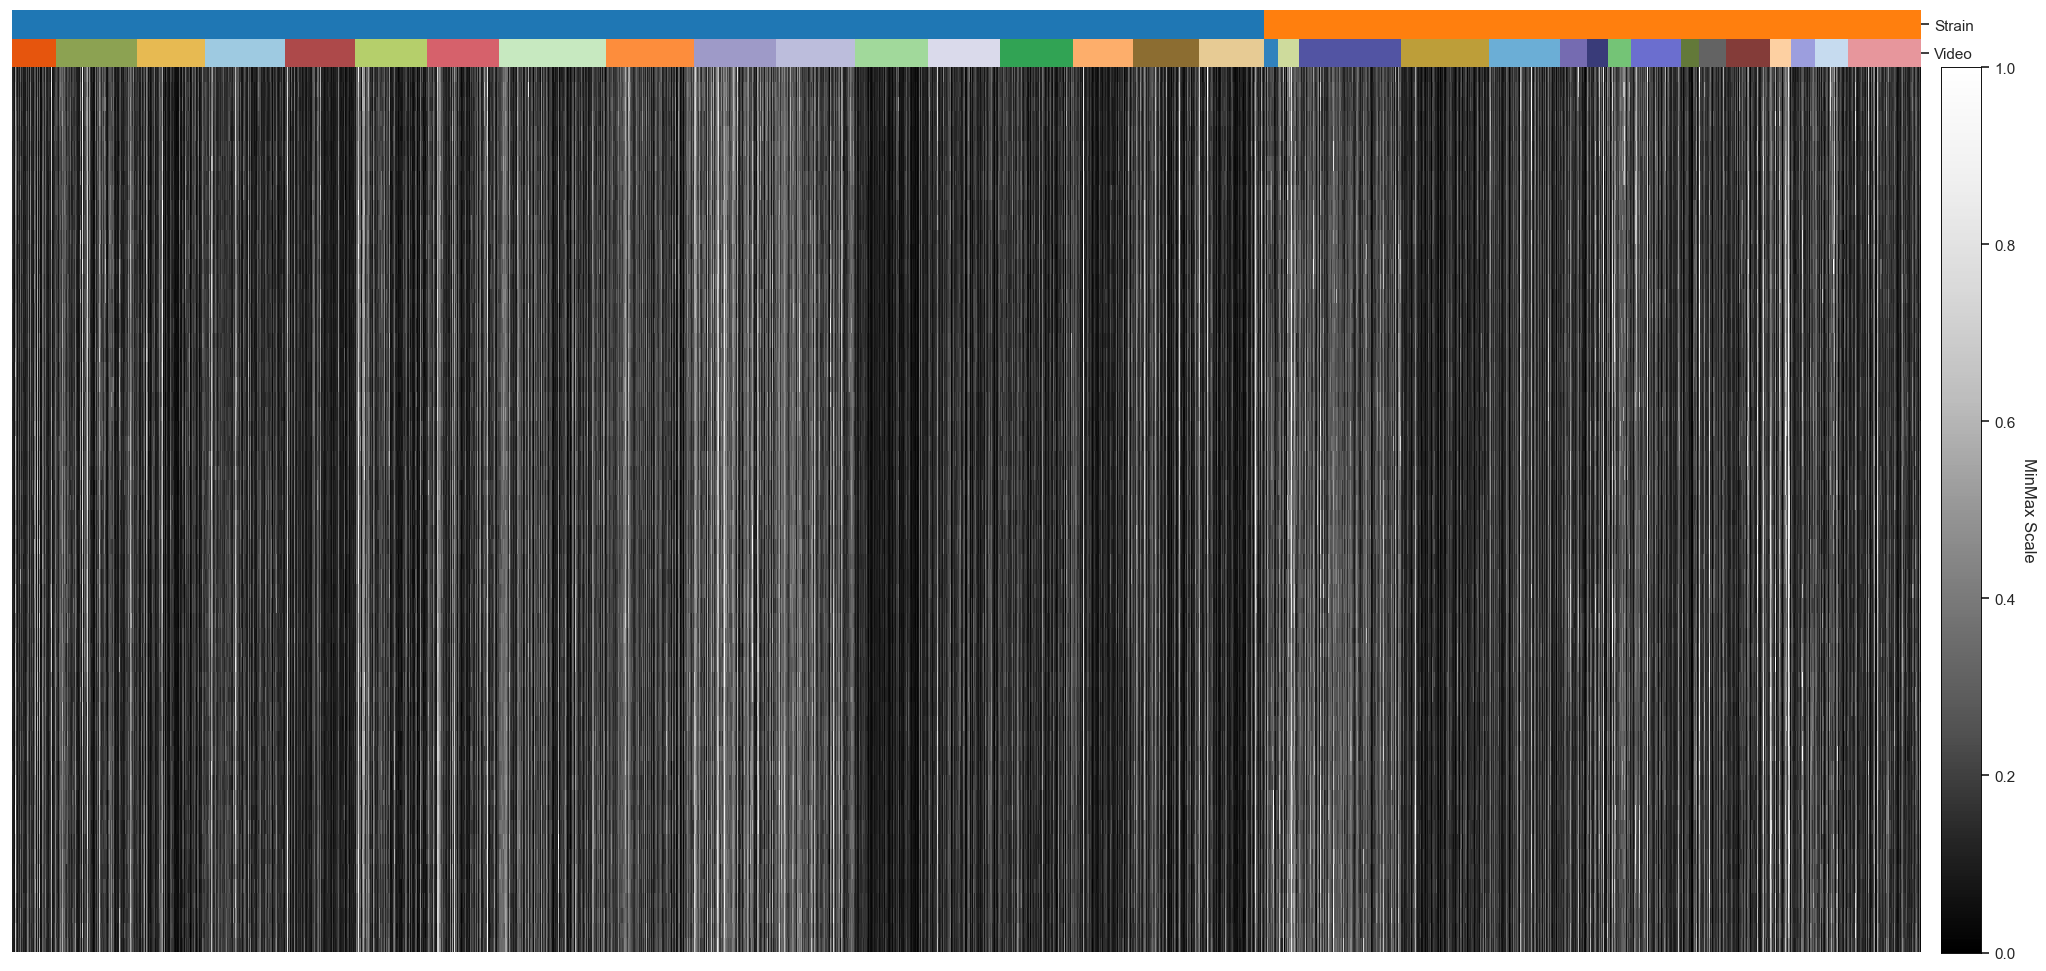

In [50]:
g = clusmapsns(df=data_norm_video, dateiname='Data_Cleaning/Heatmap_norm_by_video.png', y_label='MinMax Scale')
# Show and save
plt.show()

<h3>5.3 Clustermap norm by video</h3>

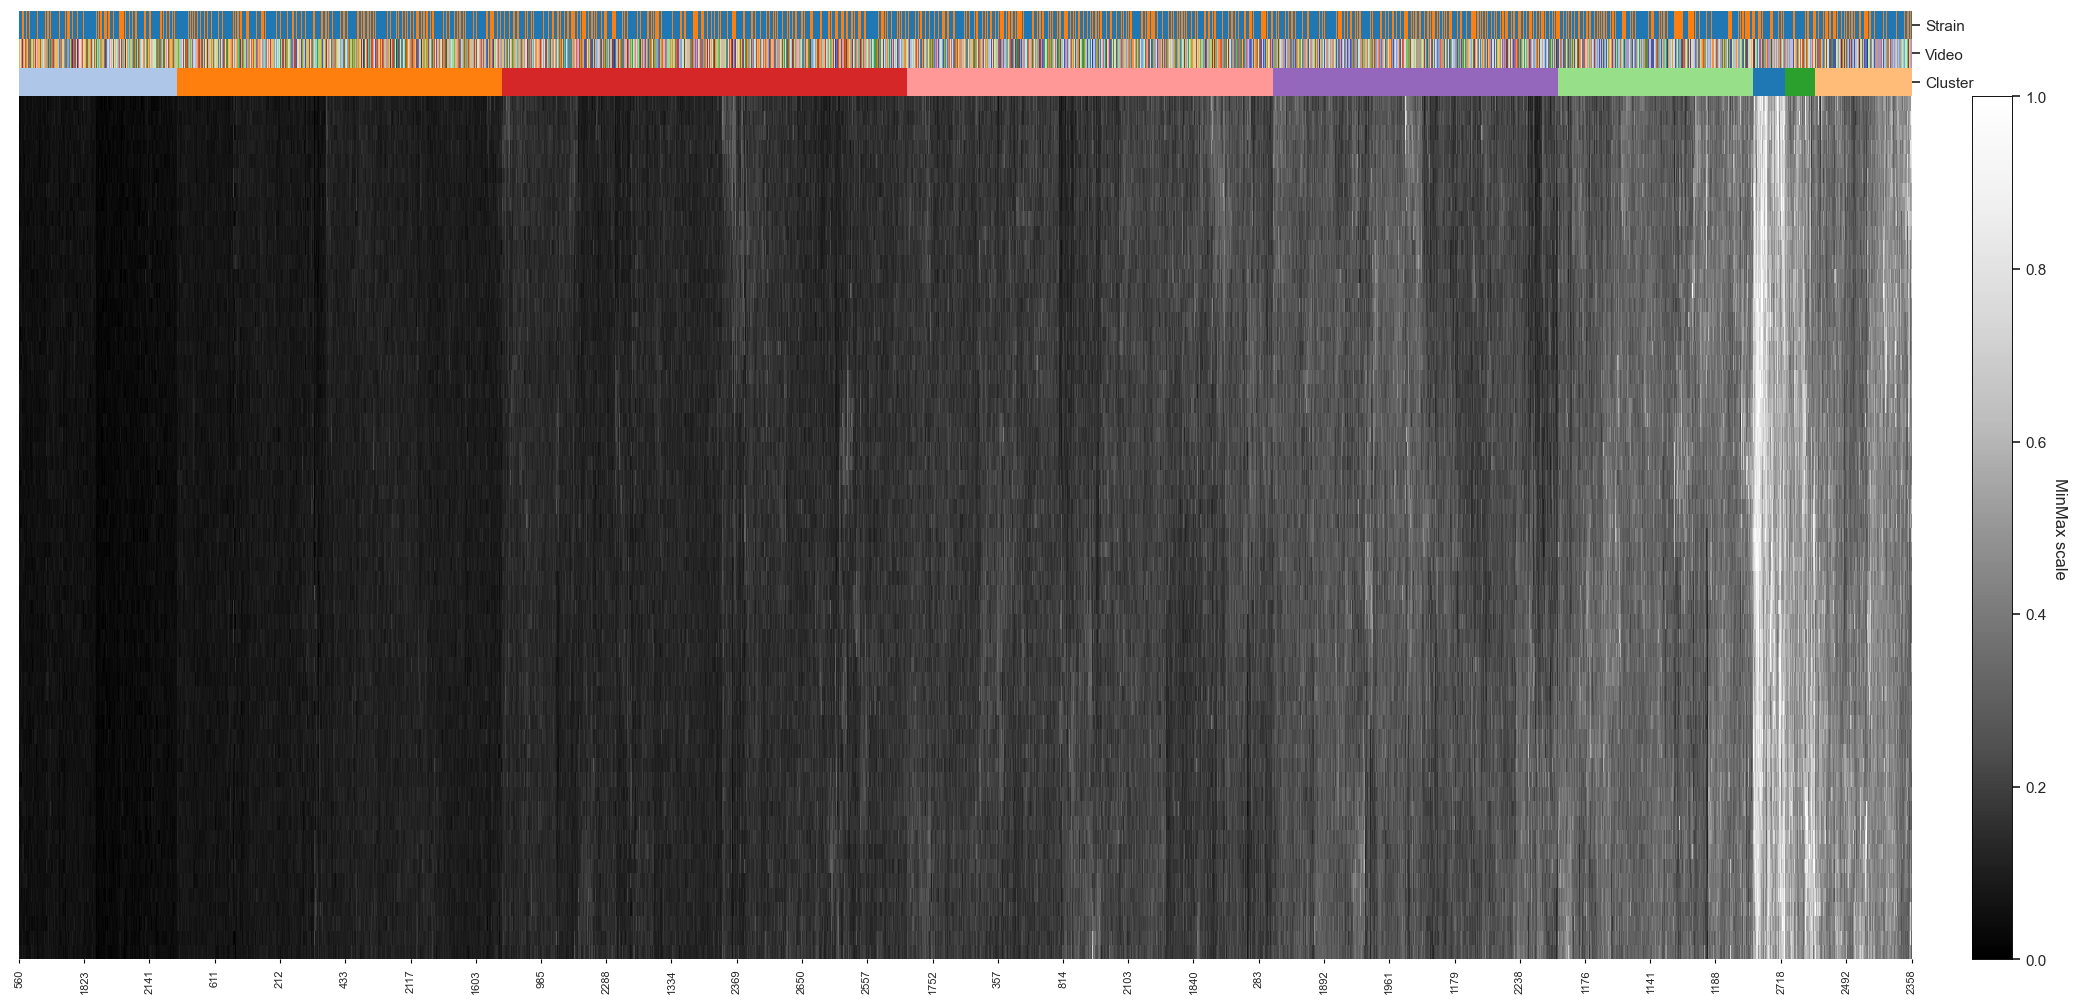

In [51]:
g, reordered, full_data_sorted = clusmapscipy_ticks(
    df=data_norm_video,
    dateiname='Data_Cleaning/Clustermap_norm_by_video_imp_ticks.png',
    output_reordered='Data_Cleaning/dataframe_reordered_clustermap_norm_by_video_imp.tsv',
    output_with_clusters='Data_Cleaning/dataframe_with_cluster_assignment_norm_by_video_imp.tsv',
    cluster=True,         # enables clustering
    n_clusters=9,         # number of clusters
    hack=False,           # enable min–max normalization if you want
    show_ticks=True       # shows numeric indices as tick labels
)
plt.show()

<h3>5.4 Subplots norm by video</h3>

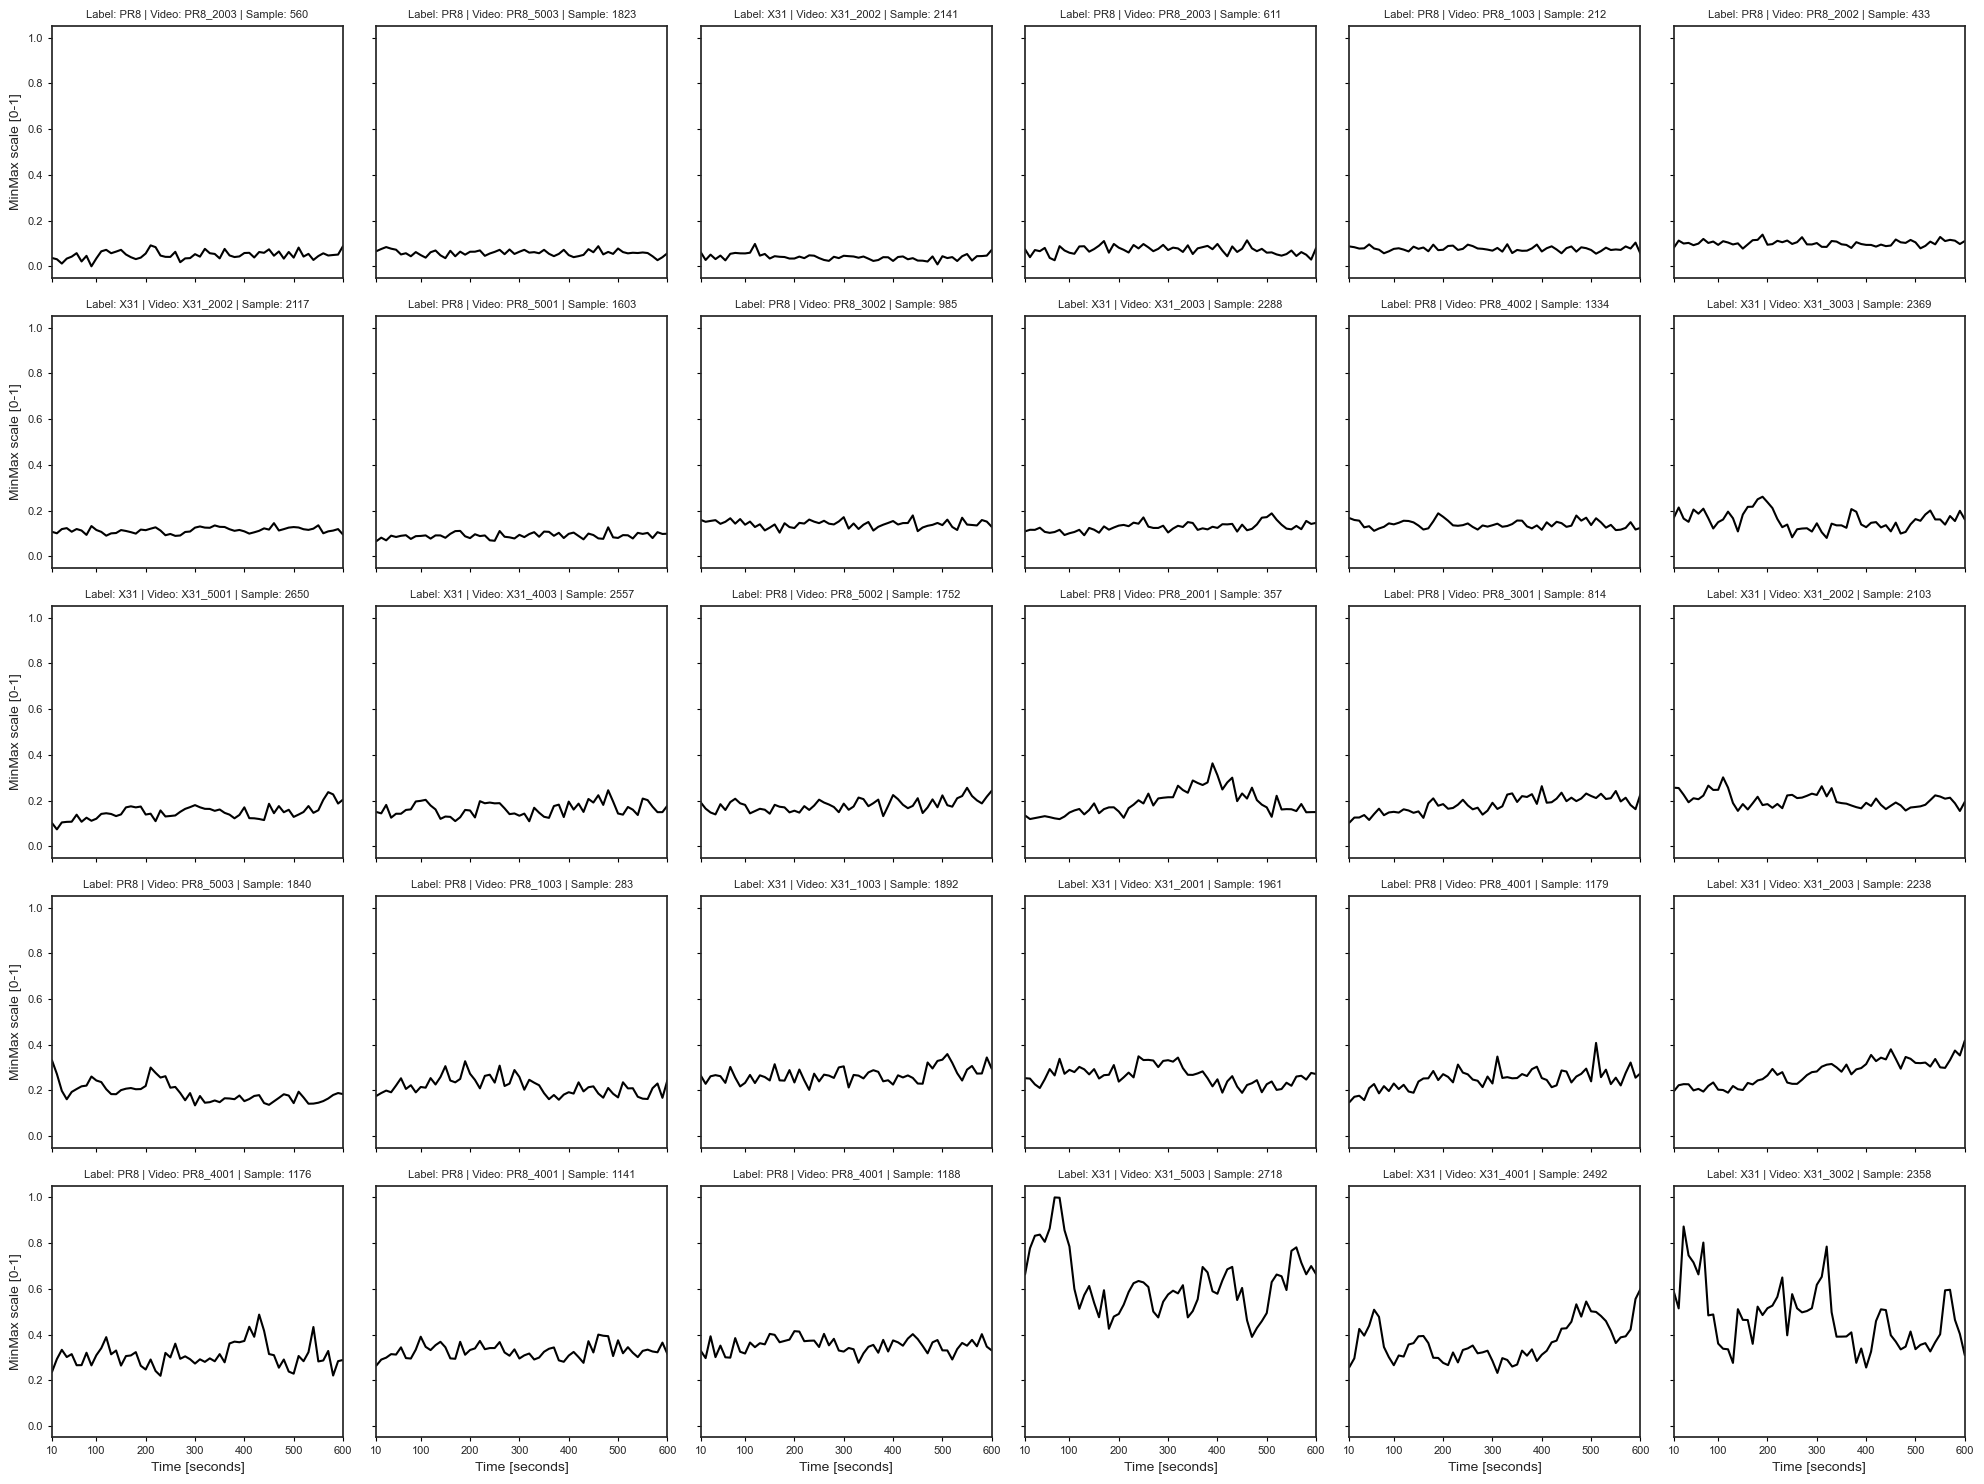

In [52]:
fig= subplt(df=reordered, dateiname='Data_Cleaning/Subplots_reordered_Clustermap_norm_by_video_imp.png')
plt.show()

<h3>5.5 Scatterplot norm by video</h3>

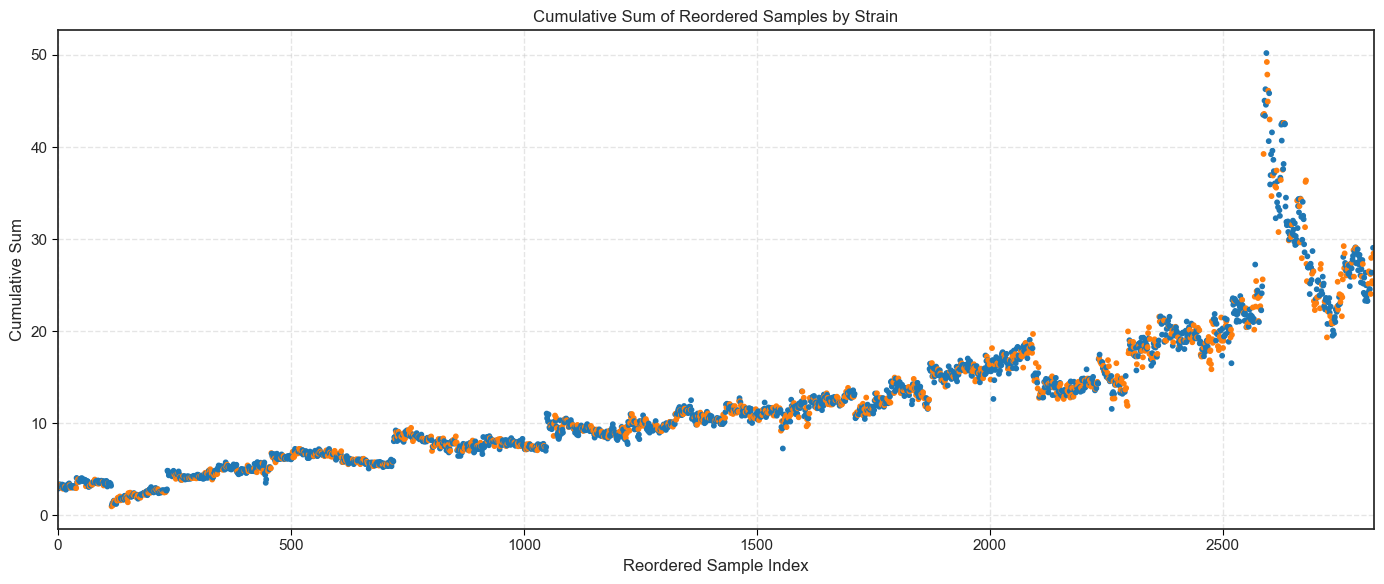

In [53]:
plt=sctplt(df=reordered,
           g=g,
           dateiname="Data_Cleaning/Scatterplot_reordered_Clustermap_norm_by_video_imp.png")
plt.show()

<h3>5.6 Clustermap (without ticks) norm by video norm and by trace</h3>

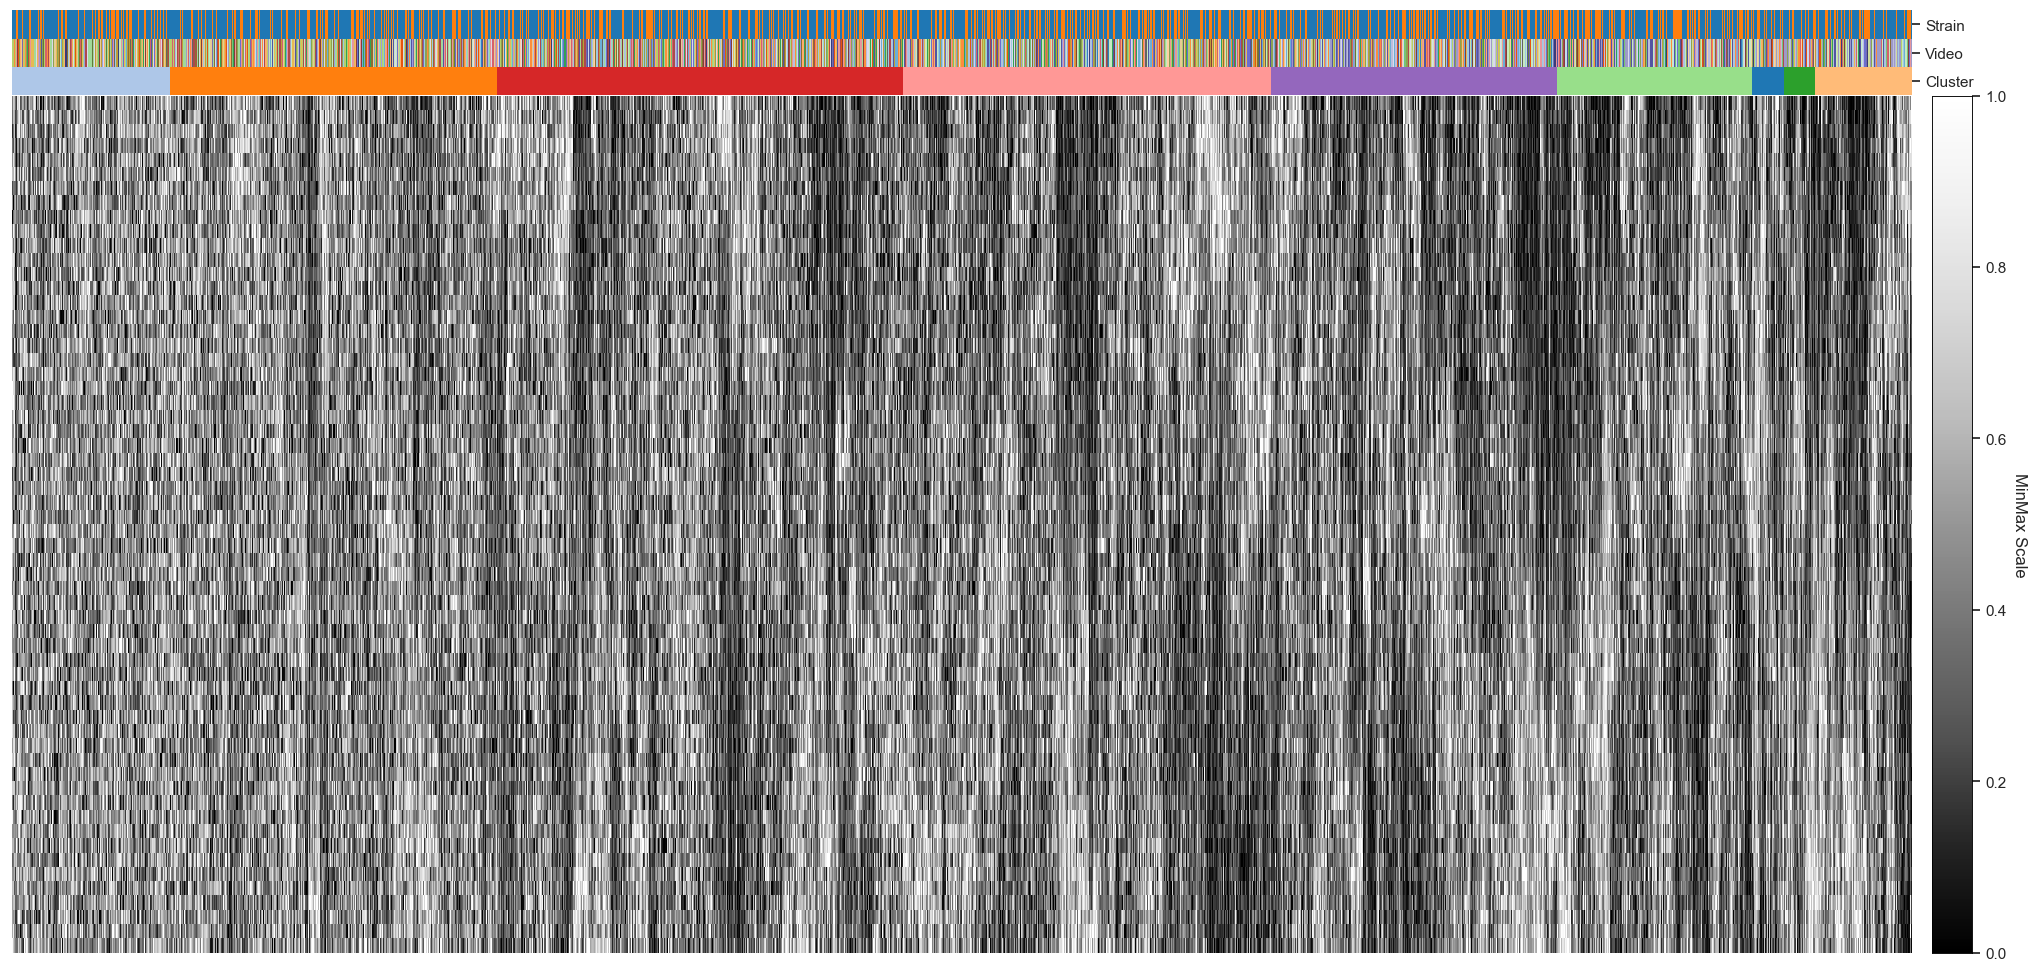

In [54]:
# Call your clusmap function with clustering and hack enabled (this does clustering internally)
g = clusmapscipy(df=data_norm_video, dateiname='Data_Cleaning/Clustermap_norm_by_video_traces_imp.png', y_label='MinMax Scale', cluster=True, n_clusters=9, hack=True)
plt.show()

<h3>5.7 Signal Background visualization norm by video dataset</h3>

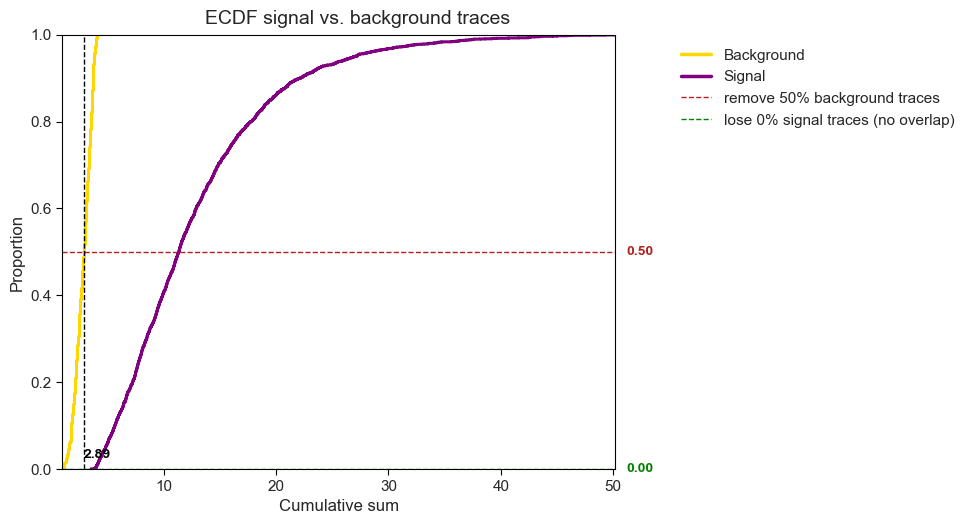

In [55]:
g2, x2, y2 = plot_ecdf_clusters(
    df=full_data_sorted,
    dateiname="Data_Cleaning/ECDF_signal_vs_background_norm_by_video_imp.png",
    signal_clusters=range(2, 10),
)

<h3>5.7 Delete Background traces from norm by video dataset</h3>

In [56]:
data_imp_background = filter_by_cumsum(
    df=data_norm_video,
    output_path="Data_Cleaning/all_traces_norm_by_video_imputation_without_background.tsv",
    threshold=2.89,
    below_threshold=True
)

Filtered out 117 traces below cumsum 2.89.
Remaining traces: 2708
